# Neck Circumference

This notebooks investigates all the possible causal paths between Sex, Height, BMI and Neck Circumference ( or any possible Ansur antropometric variable). Ultimately the goal is to assess and estimated the causal effect of Sex, Height and BMI on antropometric measurements.

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import arviz as az
import pymc as pm
import pandas as pd
import seaborn as sns
import networkx as nx
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
%config InlineBackend.figure_format = 'retina'
az.style.use("default")
plt.rcParams.update({'font.size': 12})

After reading the dataset from csv files: 
- The height given in millimeters is converted to centimeters.
- The weight is transformed into kilograms.
- BMI is computed based on the transformed height and weight values.
- The Gender column is converted into binary categorical variables. 1 represents Male, and 0 represents Female.

In [24]:
ansur_male = pd.read_csv("data/ANSUR2Distribution/Distribution/ANSUR II MALE Public.csv", encoding='latin-1') # 4082 samples
ansur_female = pd.read_csv("data/ANSUR2Distribution/Distribution/ANSUR II FEMALE Public.csv", encoding='latin-1') # 1986 samples
# Fix column name (hat tip: https://www.kaggle.com/seshadrikolluri/anthropometric-data-analysis-and-visualization)
ansur_female = ansur_female.rename(columns= {"SubjectId":"subjectid"}) 
# Combine the data and set the subjectid as index
ansur = pd.concat([ansur_male, ansur_female])
# Fix weight&stature column
ansur["stature"] = ansur["stature"]/10
ansur["weightkg"] = ansur["weightkg"]/10
ansur["neckcircumference"] = ansur["neckcircumference"]/10
ansur["BMI"] = ansur['weightkg'] / (ansur['stature']/100) **2
# Subset
columns = ['stature','BMI','neckcircumference','Gender']
subset = ansur[columns].copy()
stats = subset.groupby("Gender")[["stature","BMI",'neckcircumference']].describe()
subset['Gender'] = subset['Gender'].replace(['Male','Female'],['1','0']) # male and female with idicator variable 1== Male

In [25]:
ansur_circ = subset.neckcircumference
# height
height_std = subset.stature.std()
height_mean = subset.stature.mean()
ansur_height = subset.stature
# BMI
bmi_std = subset.BMI.std()
bmi_mean = subset.BMI.mean()
ansur_bmi = subset.BMI
s_index = subset["Gender"].astype(int).values

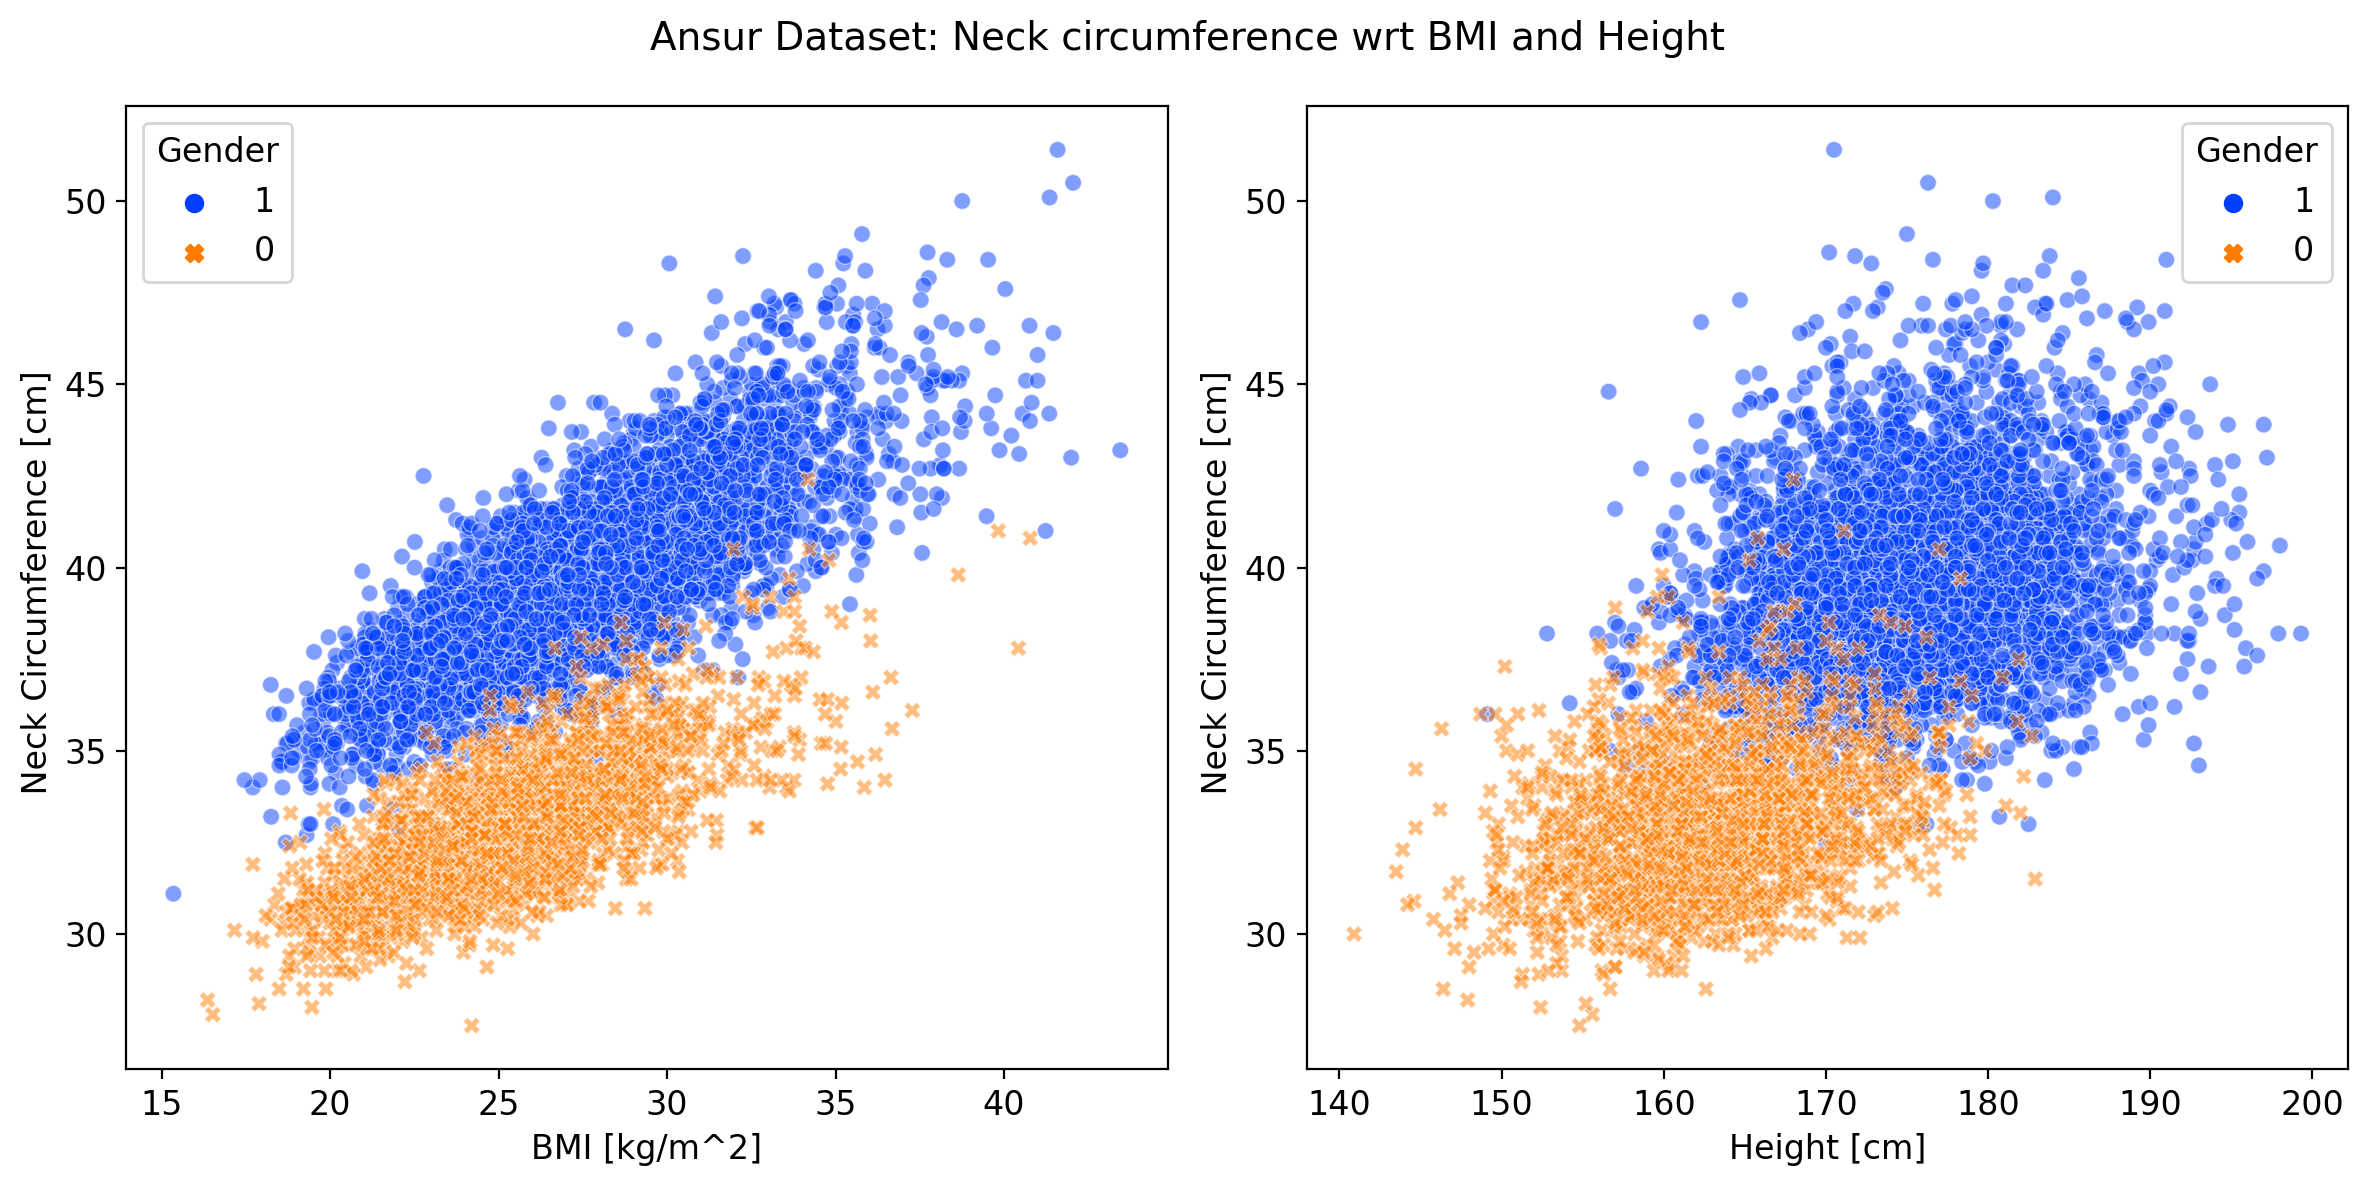

In [26]:
fig, axes = plt.subplots(1,2, figsize=(12, 6)) # male 1 and female 0
sns.scatterplot(ax = axes[0], data=subset,y="neckcircumference", x="BMI", hue="Gender", style="Gender",palette="bright", alpha = 0.5)
sns.scatterplot(ax = axes[1], data=subset,y="neckcircumference", x="stature", hue="Gender",style="Gender",palette="bright", alpha = 0.5)
axes[1].set_xlabel("Height [cm]");axes[1].set_ylabel(" Neck Circumference [cm]")
axes[0].set_xlabel("BMI [kg/m^2]");axes[0].set_ylabel(" Neck Circumference [cm]")
fig.suptitle("Ansur Dataset: Neck circumference wrt BMI and Height", fontsize = 14)
plt.tight_layout()

## The Model

In [27]:
with pm.Model() as model:
    
    # Height & bmi 
    alpha = pm.Normal("alpha", 34,10,shape=2)
    beta = pm.Normal("beta", 0,1,shape=2)
    gamma = pm.Normal("gamma", 0,1,shape=2)
    sigma = pm.Uniform("sigma", 0,10)
    mu = pm.Deterministic("mu", alpha[s_index] + beta[s_index] * (ansur_height - height_mean) + gamma[s_index] * (ansur_bmi - bmi_mean))
    neck_circ = pm.Normal("neck_circ", mu, sigma, observed = ansur_circ)  
    idata = pm.sample(draws=1000, tune=1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, gamma, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.


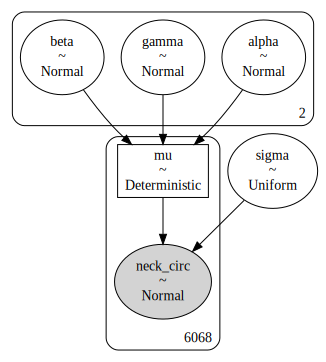

In [28]:
pm.model_to_graphviz(model)

In [29]:
az.summary(idata, var_names=["alpha", "beta", "gamma", "sigma"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha[0]  34.220  0.054  34.120   34.322      0.001    0.001    4341.0   
alpha[1]  39.097  0.026  39.050   39.147      0.000    0.000    4544.0   
beta[0]    0.077  0.005   0.068    0.086      0.000    0.000    4535.0   
beta[1]    0.073  0.003   0.067    0.079      0.000    0.000    4718.0   
gamma[0]   0.395  0.009   0.378    0.412      0.000    0.000    5774.0   
gamma[1]   0.508  0.005   0.498    0.518      0.000    0.000    6113.0   
sigma      1.398  0.013   1.375    1.422      0.000    0.000    6019.0   

          ess_tail  r_hat  
alpha[0]    3135.0    1.0  
alpha[1]    3071.0    1.0  
beta[0]     3206.0    1.0  
beta[1]     3231.0    1.0  
gamma[0]    2876.0    1.0  
gamma[1]    2954.0    1.0  
sigma       3040.0    1.0

In [30]:
with model: 
    prior_samples = pm.sample_prior_predictive(1000) # sample the priors
    pm.sample_posterior_predictive(idata, extend_inferencedata=True, random_seed=42)  # sample the posterior

Sampling: [alpha, beta, gamma, neck_circ, sigma]
Sampling: [neck_circ]


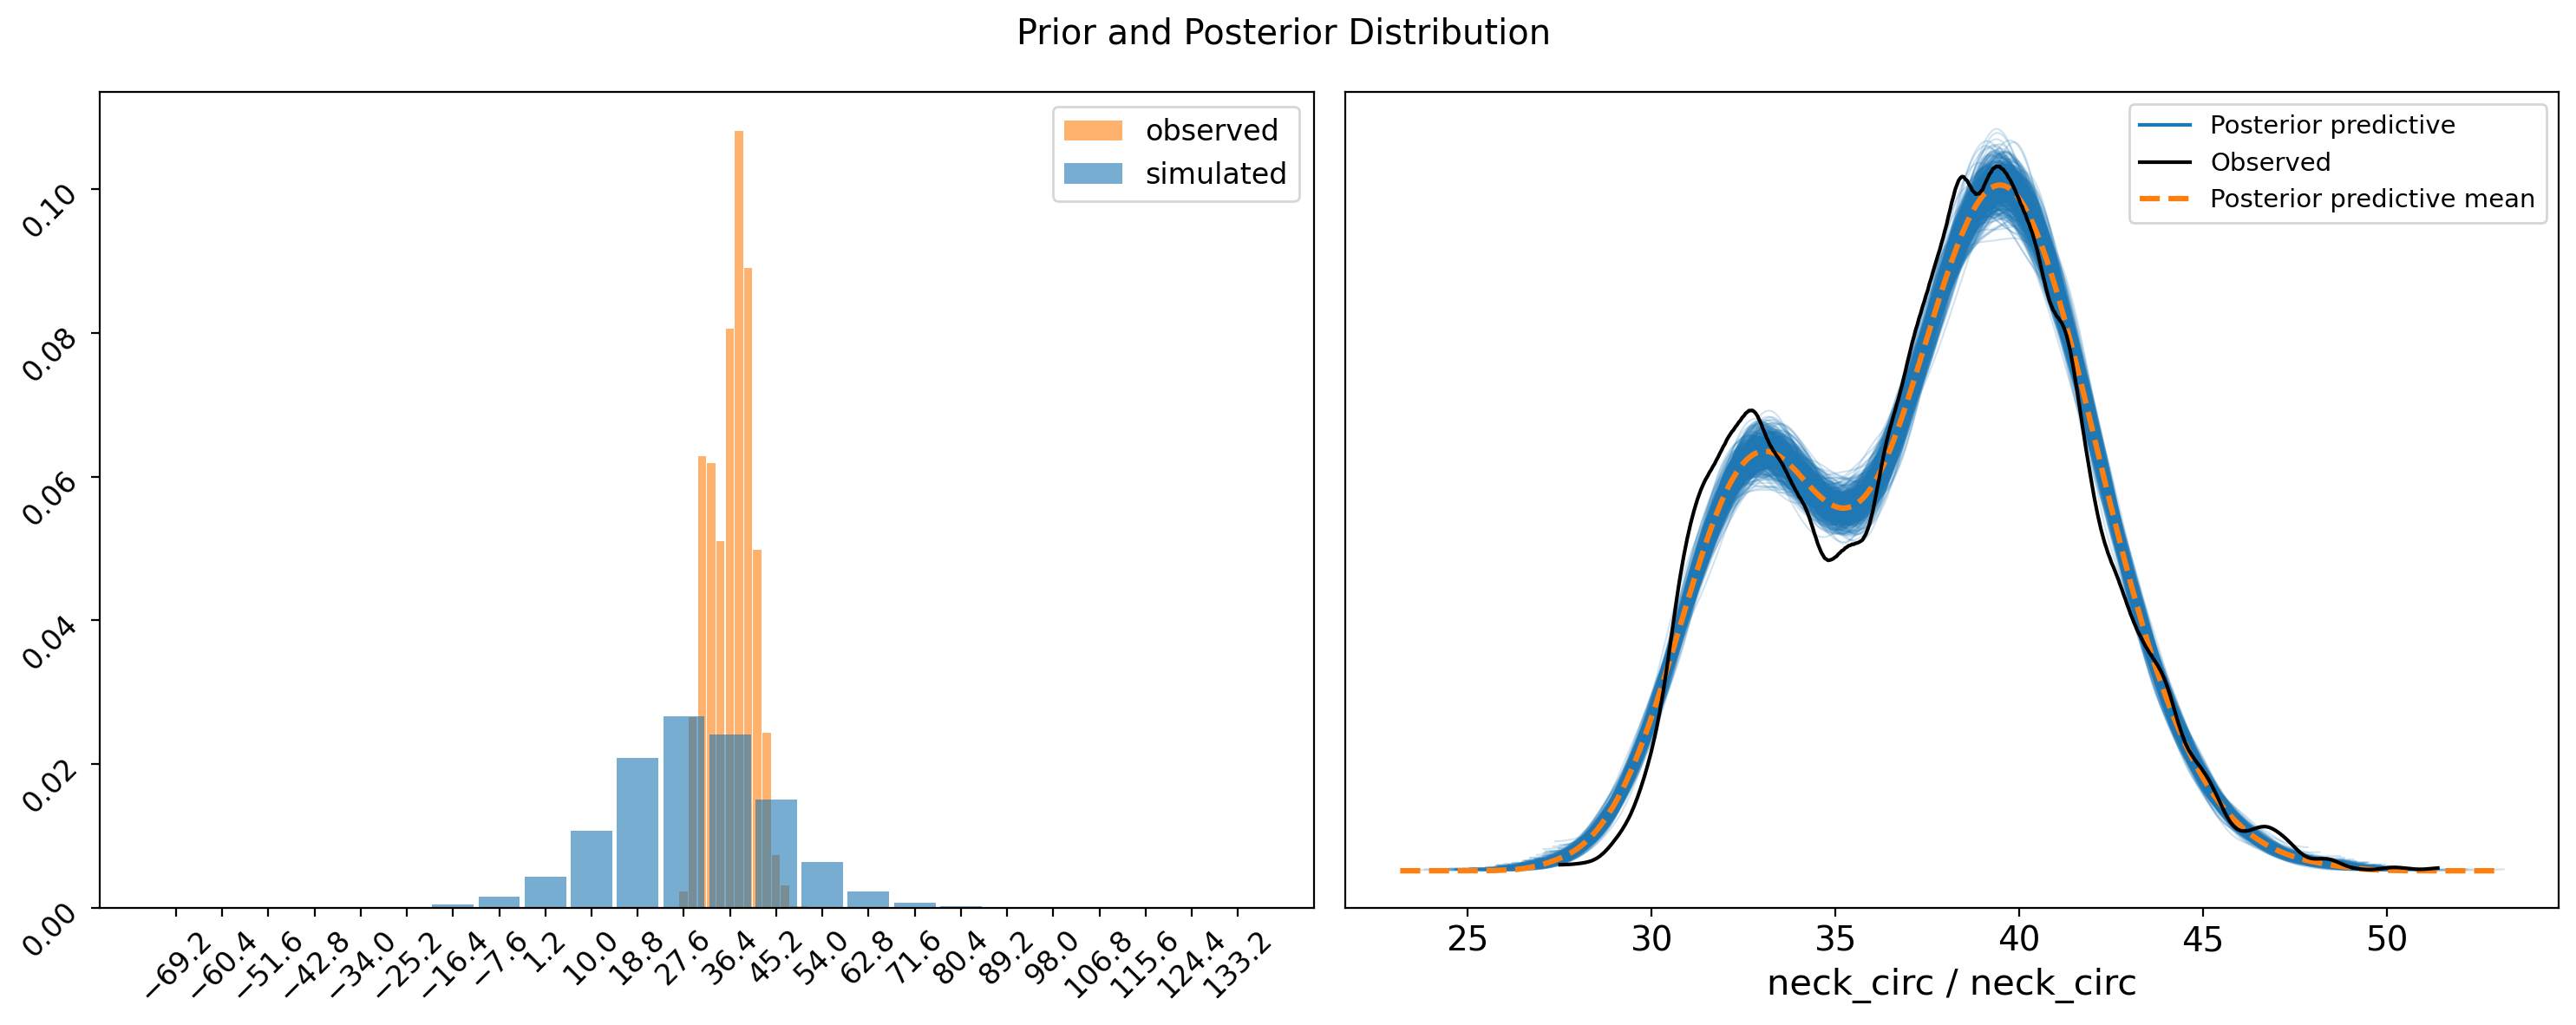

In [31]:
# plot 
fig, ax = plt.subplots(1,2,figsize=(15, 6))
fig.suptitle("Prior and Posterior Distribution ")
# plt.xticks(rotation=45);
ax[0].tick_params(labelrotation=45)
az.plot_dist(ansur_circ,kind="hist", color="C1", hist_kwargs=dict(alpha=0.6),label="observed",ax= ax[0])
az.plot_dist(prior_samples.prior_predictive["neck_circ"],kind="hist",hist_kwargs=dict(alpha=0.6),label="simulated",ax= ax[0])
az.plot_ppc(idata,var_names = "neck_circ", num_pp_samples=600, ax = ax[1])
fig.tight_layout()

In [32]:
idata_df = idata.to_dataframe()

To visualize the contribution of weight and height to the neck circumference with the mean posterior line. 
An increment in 10 cm in height contributes 0.76 cm in neck circumference for females and 0.72cm for males.
An increment of 1 BMI unit, corresponds to 0.39 cm for females and 0.5 cm for males in neck circumference. 

In [33]:
trace = az.extract(idata)

In [34]:
bmi_female = subset[subset['Gender'] == '0']['BMI']
bmi_male = subset[subset['Gender'] == '1']['BMI']
height_female = subset[subset['Gender'] == '0']['stature']
height_male = subset[subset['Gender'] == '1']['stature']

In [35]:
bmi_seq_female = np.linspace(bmi_female.min(), bmi_female.max(),4000);height_seq_female = np.linspace(height_female.min(), height_female.max(),4000)
bmi_seq_male = np.linspace(bmi_male.min(), bmi_male.max(),4000);height_seq_male = np.linspace(height_male.min(), height_male.max(),4000)

mu_pred_female = np.zeros((len(bmi_seq_female),trace.sizes["sample"]))
mu_pred_male = np.zeros((len(bmi_seq_male),trace.sizes["sample"]))
for i, (w_f,h_f,w_m,h_m) in enumerate(zip(bmi_seq_female, height_seq_female,bmi_seq_male, height_seq_male)):
    mu_pred_female[i] = trace["alpha"][0] + trace["gamma"][0] * (w_f- bmi_mean)  + trace["beta"][0] * (h_f - height_mean)
    mu_pred_male[i] = trace["alpha"][1] + trace["gamma"][1] * (w_m- bmi_mean)  + trace["beta"][1] * (h_m - height_mean)

circ_rng = np.random.default_rng(2971)
post_samples_female = [];post_samples_male = []
for _ in range(1000):  # number of samples from the posterior
    i = circ_rng.integers(len(trace))
    mu_pr_female = trace["alpha"][0][i].item(0) + trace["gamma"][0][i].item(0) * (bmi_seq_female - bmi_mean) + trace["beta"][0][i].item(0) * (height_seq_female - height_mean)
    mu_pr_male = trace["alpha"][1][i].item(0) + trace["gamma"][1][i].item(0) * (bmi_seq_male - bmi_mean) + trace["beta"][1][i].item(0) * (height_seq_male - height_mean)
    sigma_pred = trace["sigma"][i]
    post_samples_female.append(circ_rng.normal(mu_pr_female, sigma_pred))
    post_samples_male.append(circ_rng.normal(mu_pr_male, sigma_pred))

c:\Users\chiarar\Anaconda3\envs\bayes\Lib\site-packages\arviz\plots\hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
c:\Users\chiarar\Anaconda3\envs\bayes\Lib\site-packages\arviz\plots\hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
c:\Users\chiarar\Anaconda3\envs\bayes\Lib\site-packages\arviz\plots\hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
c:\U

Text(0, 0.5, 'Neck Circumference [cm]')

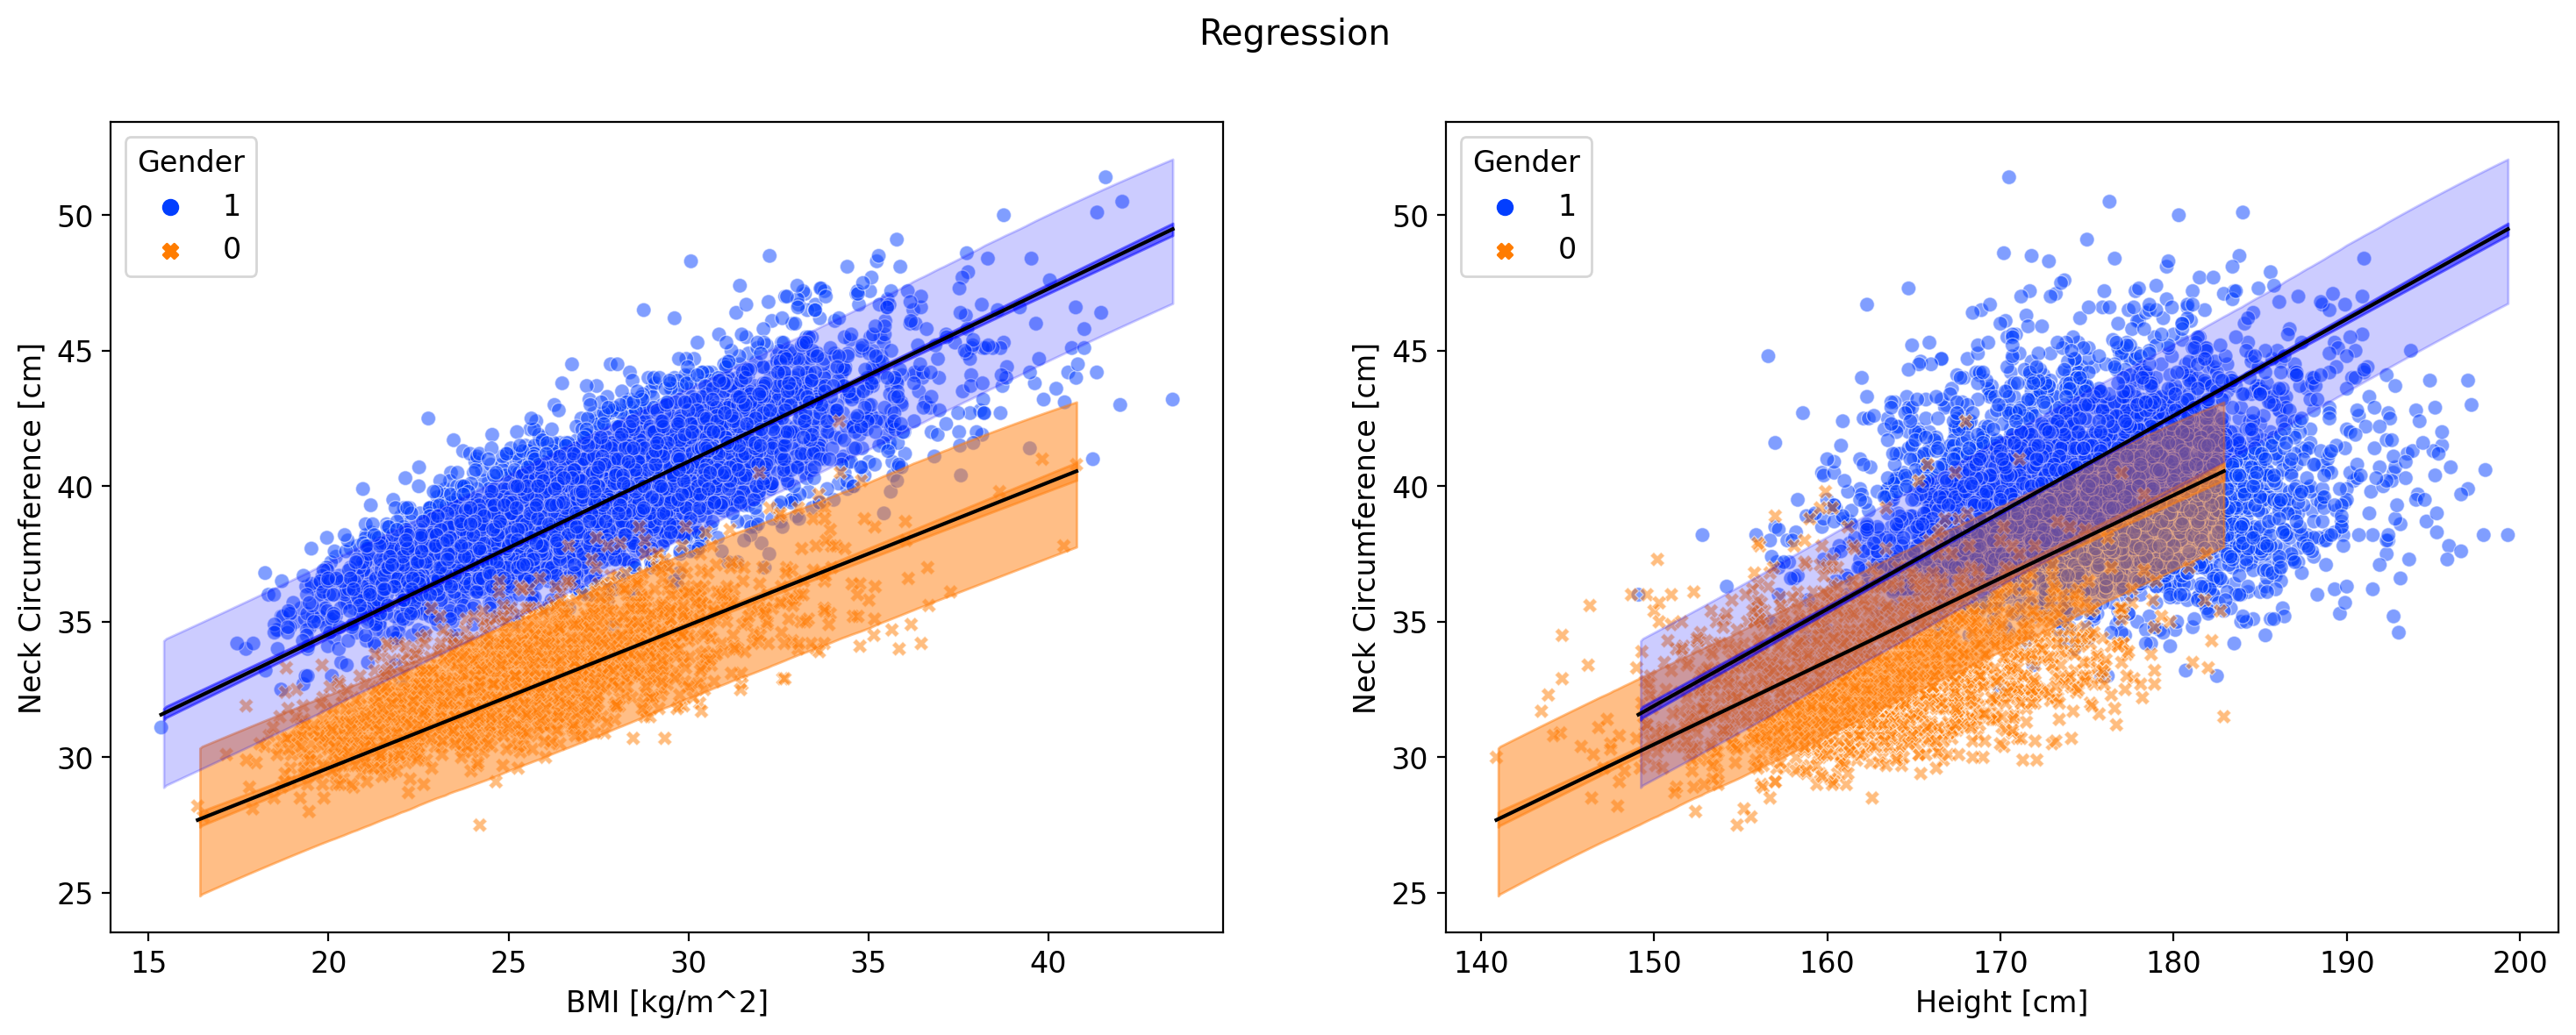

In [36]:
# PLOTS
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(18, 6))
fig.suptitle("Regression")    
sns.scatterplot(data=subset,y="neckcircumference", x="BMI", hue="Gender", alpha = 0.5, ax= ax0, style="Gender",palette="bright")
# BMI
az.plot_hdi(bmi_seq_female, mu_pred_female.T, hdi_prob=0.95,ax=ax0)
az.plot_hdi(bmi_seq_female, np.array(post_samples_female), ax=ax0, hdi_prob=0.95)
ax0.plot(bmi_seq_female,mu_pred_female.mean(1), "k")
az.plot_hdi(bmi_seq_male, mu_pred_male.T, hdi_prob=0.95,ax= ax0, color="blue")
az.plot_hdi(bmi_seq_male, np.array(post_samples_male), ax=ax0, hdi_prob=0.95,color="blue",fill_kwargs={"alpha": .2})
ax0.plot(bmi_seq_male,mu_pred_male.mean(1), "k")
# Height 
sns.scatterplot(data=subset,y="neckcircumference", x="stature", hue="Gender", alpha = 0.5,ax= ax1, style="Gender",palette="bright")
az.plot_hdi(height_seq_female, mu_pred_female.T, hdi_prob=0.95,ax= ax1)
az.plot_hdi(height_seq_female, np.array(post_samples_female), ax=ax1, hdi_prob=0.95)
ax1.plot(height_seq_female,mu_pred_female.mean(1), "k")
az.plot_hdi(height_seq_male, mu_pred_male.T, hdi_prob=0.95,color="blue",ax=ax1)
az.plot_hdi(height_seq_male, np.array(post_samples_male), ax=ax1, hdi_prob=0.95,color="blue",fill_kwargs={"alpha": .2})
ax1.plot(height_seq_male,mu_pred_male.mean(1), "k")

ax1.set_xlabel("Height [cm]"); ax1.set_ylabel("Neck Circumference [cm]")
ax0.set_xlabel("BMI [kg/m^2]");ax0.set_ylabel("Neck Circumference [cm]")

##### Posterior Mean

Plot the mean posterior for a sample of 1000 female and males

Mean for female: 32.923 cm
Mean for male: 39.897 cm

PLOT 2:
Mean of the difference: 6.973 cm


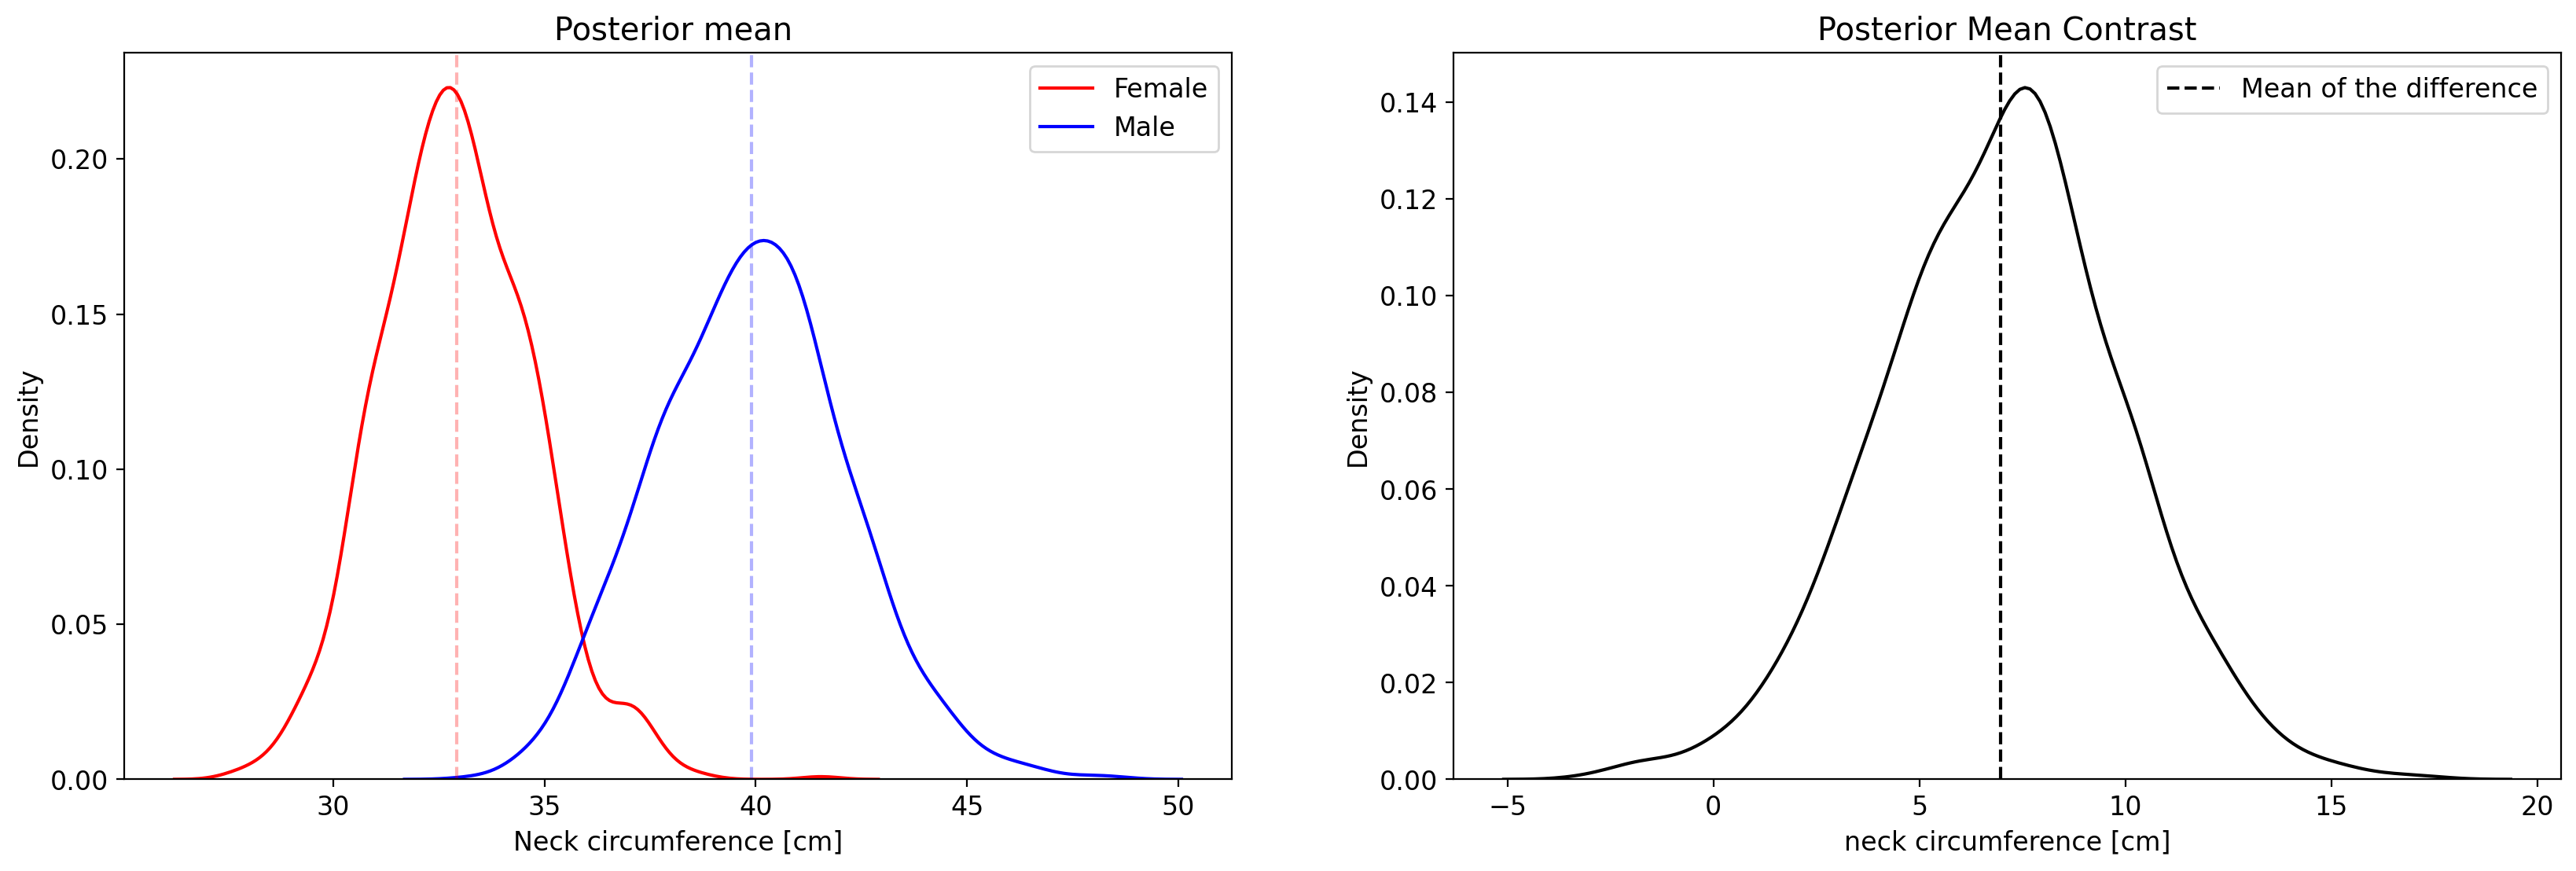

In [37]:
mu_female = norm.rvs(loc= (idata_df[("posterior", "alpha[0]", 0)][:1000] + idata_df[("posterior", "gamma[0]", 0)][:1000] * (bmi_female[:1000]  - bmi_mean) + idata_df[("posterior", "beta[0]", 0)][:1000] * (height_female[:1000]  - height_mean) ), size =1000 )
mu_male = norm.rvs(loc= (idata_df[("posterior", "alpha[1]", 1)][:1000] + idata_df[("posterior", "gamma[1]", 1)][:1000] * (bmi_male[:1000] - bmi_mean) + idata_df[("posterior", "beta[1]", 1)][:1000] * (height_male[:1000] - height_mean) ), size =1000 )
f, ax = plt.subplots(1,2 , figsize=(20, 6))
ax[0].set_title("Posterior mean ")
ax[0].set_xlabel("Neck circumference [cm]")
sns.kdeplot( mu_female, color="red", ax=ax[0], label= "Female")
sns.kdeplot( mu_male , color="blue", ax=ax[0], label= "Male")
ax[0].axvline(x=(np.mean(mu_female)), linestyle="dashed", color="red",alpha=0.3)
ax[0].axvline(x=(np.mean(mu_male)), linestyle="dashed", color="blue",alpha=0.3)
print(f"Mean for female:", np.round(np.nanmean(mu_female),3), "cm")
print(f"Mean for male:", np.round(np.nanmean(mu_male),3), "cm")
ax[1].set_title("Posterior Mean Contrast")
ax[1].set_xlabel("neck circumference [cm]")
mu_contrast = mu_male - mu_female
sns.kdeplot(mu_contrast,color='black' ,ax=ax[1])

kde_x, kde_y = ax[1].lines[0].get_data()
ax[1].axvline(x=np.nanmean(mu_contrast), linestyle="dashed", color="black", label= "Mean of the difference")
ax[0].legend(); ax[1].legend();
print(f"\nPLOT 2:")
print(f"Mean of the difference:", np.round(np.nanmean(mu_contrast),3), "cm")

##### Posterior Distribution

Proportion above zero: 0.982
Proportion below zero: 0.018


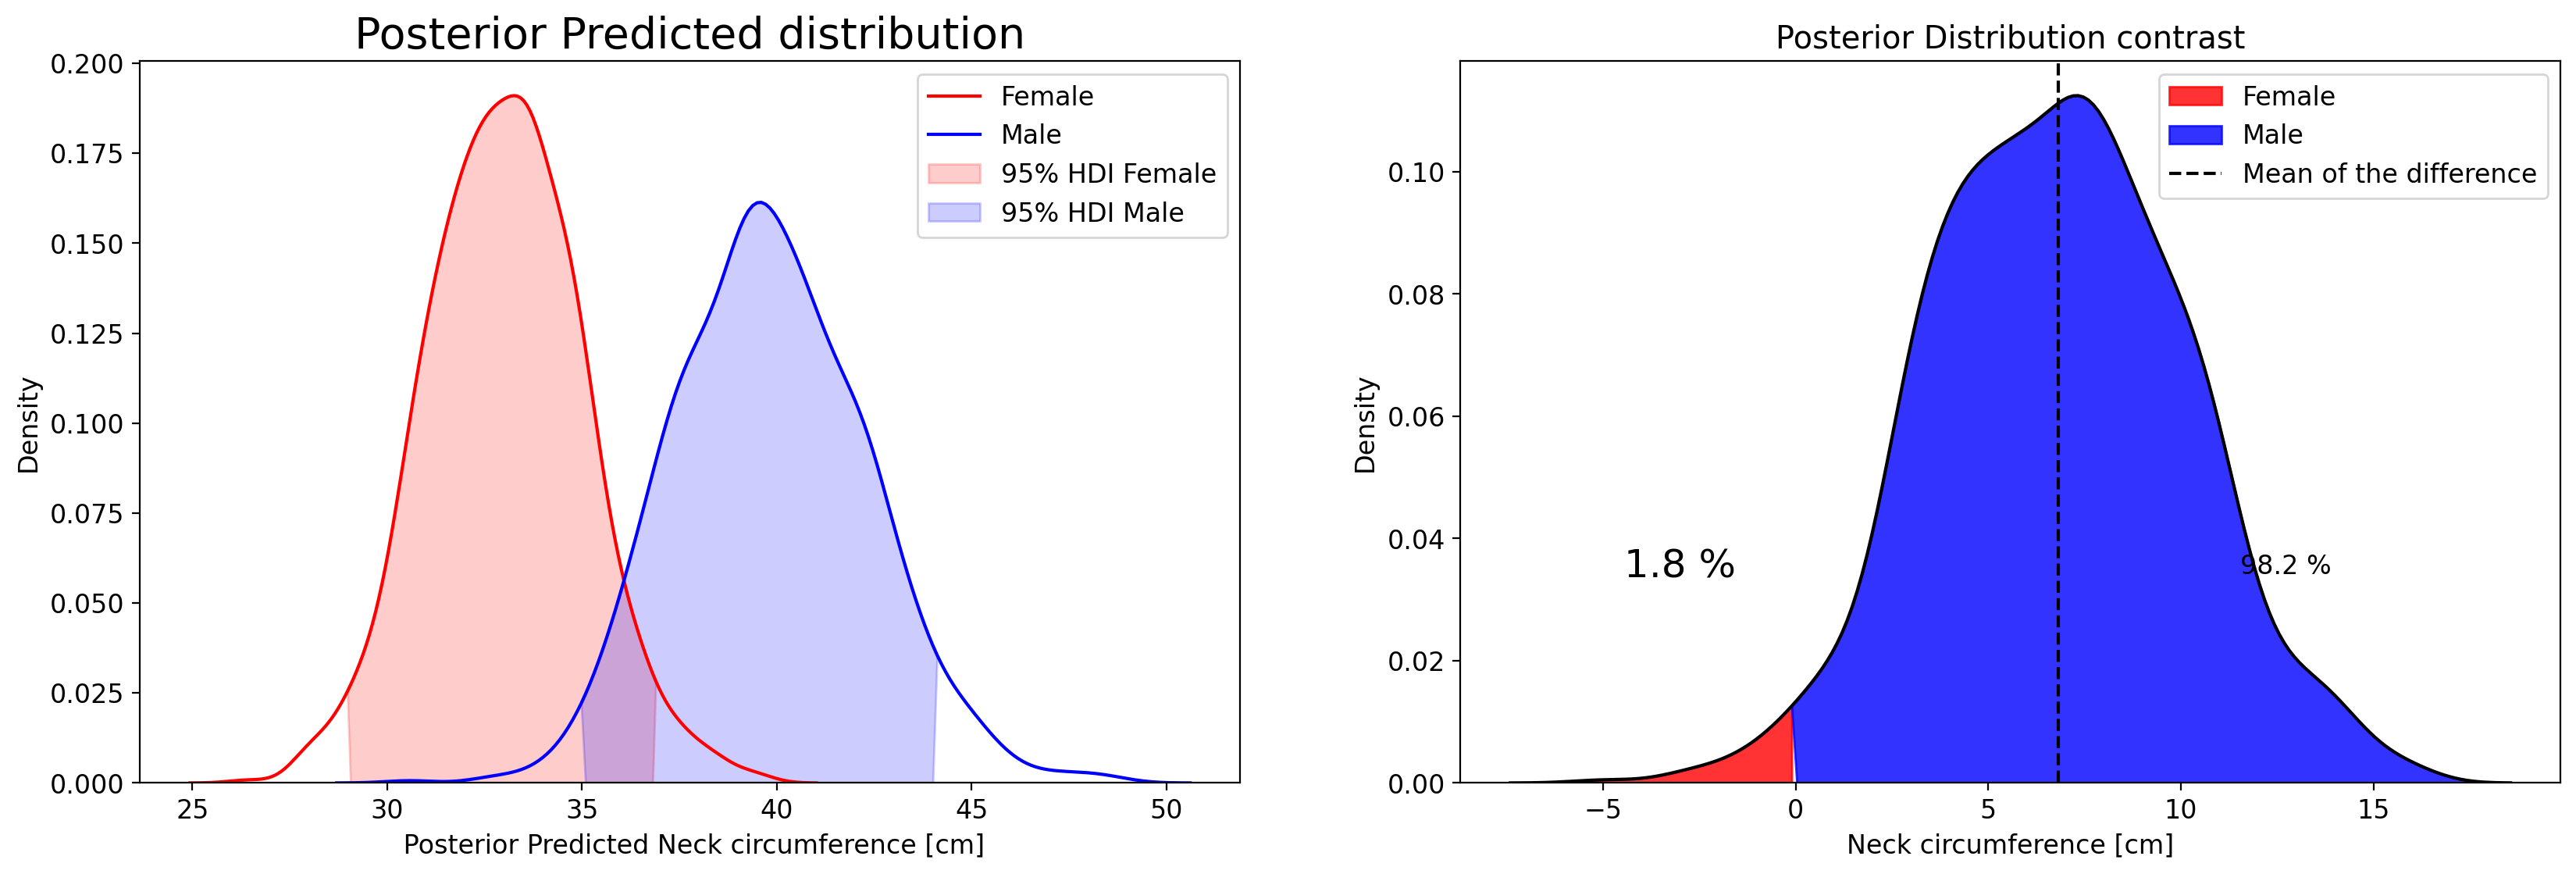

In [38]:
#| label: fig-contrast-distribution
#| fig-cap: "Posterior Distribution Contrast Neck Circumference"
# posterior W distributions
f, ax = plt.subplots(1,2, figsize=(20, 6))
N0 = norm.rvs(loc= (idata_df[("posterior", "alpha[0]", 0)] + idata_df[("posterior", "gamma[0]", 0)] * (bmi_female[:1000] - bmi_mean) + idata_df[("posterior", "beta[0]", 0)] * (height_female[:1000] - height_mean) ), scale =idata_df[("posterior", "sigma")] )
N1 = norm.rvs(loc= (idata_df[("posterior", "alpha[1]", 1)] + idata_df[("posterior", "gamma[1]", 1)] * (bmi_male[:1000] - bmi_mean)   + idata_df[("posterior", "beta[1]", 1)] * (height_male[:1000] - height_mean) ),   scale =idata_df[("posterior", "sigma")] )
sns.kdeplot(N0, color="red", label="Female", ax=ax[0])
sns.kdeplot(N1, color="blue", label="Male", ax=ax[0])

# HDI
#-----------------------
kde_female_x, kde_female_y = ax[0].lines[0].get_data()
low_female_int, high_female_int = az.hdi(N0[~np.isnan(N0)], hdi_prob=.95)
ax[0].fill_between(kde_female_x, kde_female_y, where=(low_female_int< kde_female_x)& ( kde_female_x <high_female_int), color="red", alpha= 0.2, label="95% HDI Female",interpolate=True)
kde_male_x, kde_male_y = ax[0].lines[1].get_data()
low_male_int, high_male_int = az.hdi(N1[~np.isnan(N1)])
ax[0].fill_between(kde_male_x, kde_male_y, where=(low_male_int< kde_male_x)& ( kde_male_x <high_male_int), color="blue", alpha= 0.2, label="95% HDI Male",interpolate=True)
#------------------------------
ax[0].set(xlabel=" Posterior Predicted Neck circumference [cm]"); ax[0].set_title("Posterior Predicted distribution", fontsize=20)
ax[0].legend()

# contrast
N_contrast = N1 - N0
ax[1].set_title("Posterior Distribution contrast")
sns.kdeplot(N_contrast, color="black", ax=ax[1])
kde_x, kde_y = ax[1].lines[0].get_data()
ax[1].fill_between(kde_x, kde_y, where=kde_x < 0, color="red", alpha= 0.8, label="Female",interpolate=True)
ax[1].fill_between(kde_x, kde_y, where=kde_x > 0, color="blue", alpha= 0.8,label="Male", interpolate=True)
ax[1].set(xlabel="Neck circumference [cm]")
# proportion above zero
print(f"Proportion above zero: {np.round(sum((N_contrast[~np.isnan(N_contrast)]) > 0)  / len(N_contrast[~np.isnan(N_contrast)]),3)}")
# proportion below zero
print(f"Proportion below zero: {np.round(sum((N_contrast[~np.isnan(N_contrast)]) < 0)  / len(N_contrast[~np.isnan(N_contrast)]),3)}")
ax[1].axvline(x= np.nanmean(N_contrast), linestyle="dashed", color="black", label= "Mean of the difference")
perc = np.round(sum((N_contrast[~np.isnan(N_contrast)]) > 0)  / len(N_contrast[~np.isnan(N_contrast)]),3)
ax[1].text(0.75, 0.3, "%.1f %%"%(perc*100), horizontalalignment='center', verticalalignment='center', transform=ax[1].transAxes)
ax[1].text(0.2, 0.3, "%.1f %%"%((1-perc)*100), horizontalalignment='center', verticalalignment='center', transform=ax[1].transAxes, fontsize = 18)

ax[1].legend()

Create a sample of 50 individual and plot the posterior contrast on height and BMI. 

Contrast (Male - Female) for individual with average height or BMI for 50 samples.

Fixed Height - BMI varies 14 to 44 kg/m^2

Fixed BMI - Height varies 120-190 

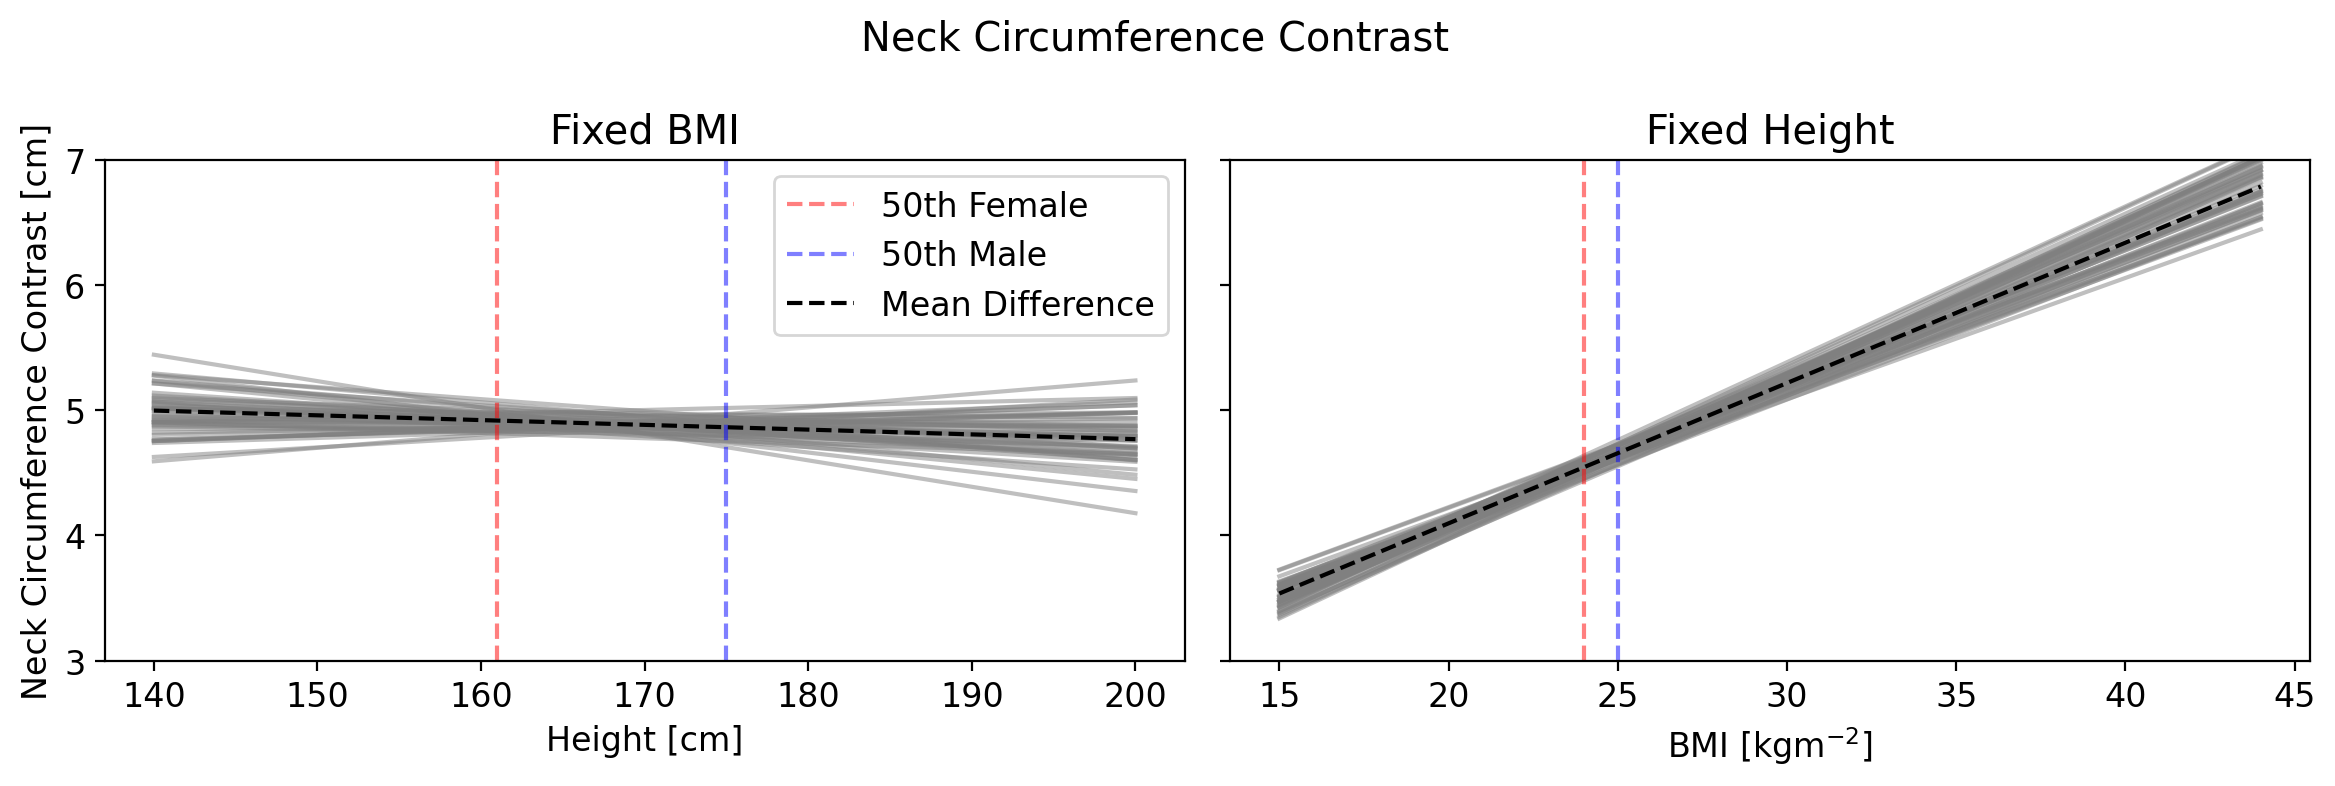

In [39]:
#| label: fig-contrast
#| fig-cap: "Posterior Contrast Neck Circumference"
bmi_seq = np.linspace(15, 44, num=50)
hseq = np.linspace(140, 200, num=50)
# initialize dataframes
mu_F_bmi = np.zeros((len(idata_df), len(bmi_seq)))
mu_M_bmi = np.zeros((len(idata_df), len(bmi_seq)))
# Fill female and male predictions
for i, (x, h) in enumerate(zip(bmi_seq,hseq)):
    mu_F_bmi[:, i] = idata_df[("posterior", "alpha[0]", 0)] + idata_df[("posterior", "gamma[0]", 0)] * (x - bmi_mean)  
    mu_M_bmi[:, i] = idata_df[("posterior", "alpha[1]", 1)] + idata_df[("posterior", "gamma[1]", 1)] * (x - bmi_mean) 
mu_contrast_MF_bmi= mu_M_bmi - mu_F_bmi

# initialize dataframes
mu_F_height = np.zeros((len(idata_df), len(bmi_seq)))
mu_M_height = np.zeros((len(idata_df), len(bmi_seq)))
# Fill female and male predictions
for i, (x, h) in enumerate(zip(bmi_seq,hseq)):
    mu_F_height[:, i] = idata_df[("posterior", "alpha[0]", 0)] + idata_df[("posterior", "beta[0]", 0)] * (h - height_mean) 
    mu_M_height[:, i] = idata_df[("posterior", "alpha[1]", 1)] + idata_df[("posterior", "beta[1]", 1)] * (h - height_mean) 
mu_contrast_MF_height= mu_M_height - mu_F_height

f, ((ax0, ax1)) = plt.subplots(1, 2,figsize=(12, 4),sharey=True)
f.suptitle("Neck Circumference Contrast")
for i in range(50):
    ax1.plot(bmi_seq, mu_contrast_MF_bmi[i, :], color="gray", alpha=0.5)
    ax0.plot(hseq, mu_contrast_MF_height[i, :], color="gray", alpha=0.5)

ax1.axvline(x= 24, linestyle="dashed", color="red", label= "50th Female", alpha = 0.5)
ax1.axvline(x= 25, linestyle="dashed", color="blue", label= "50th Male", alpha = 0.5)
ax0.axvline(x= 161, linestyle="dashed", color="red", label= "50th Female", alpha = 0.5)
ax0.axvline(x= 175, linestyle="dashed", color="blue", label= "50th Male", alpha = 0.5)       
ax0.plot(hseq, mu_contrast_MF_height.mean(axis=0), color="black", linestyle='--', label ="Mean Difference")
ax0.set(xlabel="Height [cm]", ylabel="Neck Circumference Contrast [cm]")
ax1.plot(bmi_seq, mu_contrast_MF_bmi.mean(axis=0), color="black", linestyle='--')
ax1.set(xlabel="BMI [kgm$^{-2}$]");ax1.set_title("Fixed Height");ax0.set_title("Fixed BMI");ax0.set_ylim([3,8])
ax0.legend()
ax0.set_ylim([3,7])
f.tight_layout()
# plt.savefig("images/Neck_circumference-contrast.png")

In [40]:
male_data = subset[subset['Gender'] == 1]
female_data = subset[subset['Gender'] == 0]
# Determine the overlapping range for height
height_min = max(male_data['stature'].min(), female_data['stature'].min())
height_max = min(male_data['stature'].max(), female_data['stature'].max())

# Determine the overlapping range for BMI
bmi_min = max(male_data['BMI'].min(), female_data['BMI'].min())
bmi_max = min(male_data['BMI'].max(), female_data['BMI'].max())

height_range = np.linspace(height_min, height_max, 100)
bmi_range = np.linspace(bmi_min, bmi_max, 100)

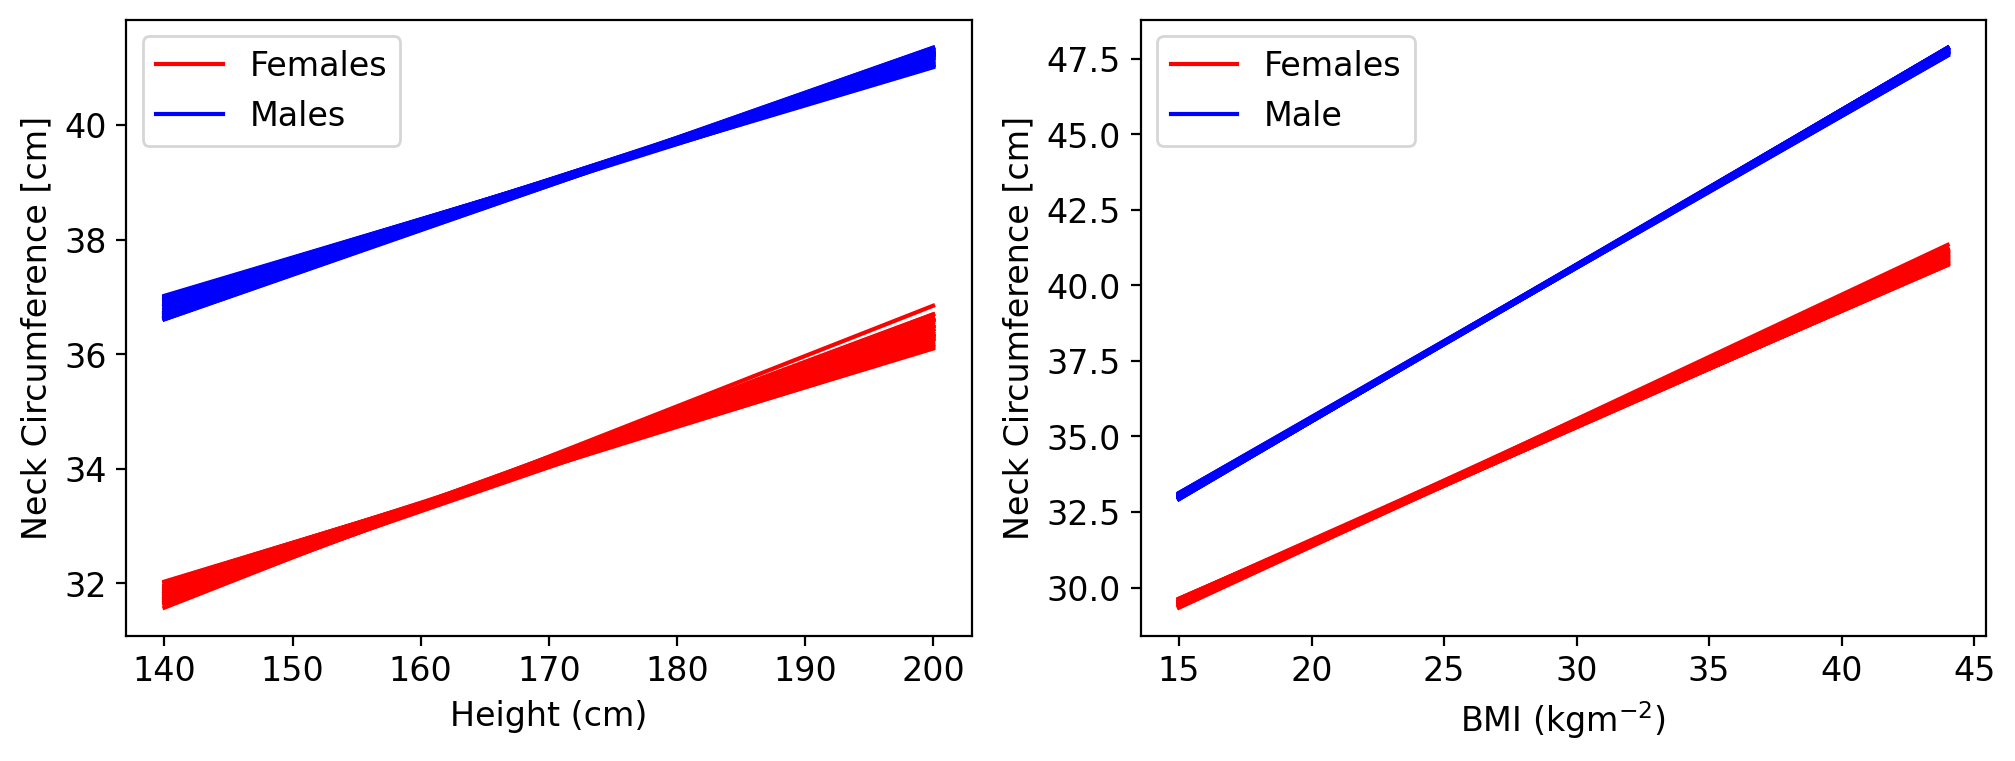

In [42]:
f, ((ax2,ax3)) = plt.subplots(1, 2, figsize=(12, 4))
for i in range(50):
    if i == 0:
        ax2.plot(hseq, mu_F_height[i, :], color="red", label="Females")
        ax2.plot(hseq, mu_M_height[i, :], color="blue", label="Males")
    else:
        ax2.plot(hseq, mu_F_height[i, :], color="red")
        ax2.plot(hseq, mu_M_height[i, :], color="blue")
ax2.set(xlabel="Height (cm)", ylabel="Neck Circumference [cm]")
ax2.legend()
for i in range(50):
    if i == 0:
        ax3.plot(bmi_seq, mu_F_bmi[i, :], color="red", label="Females")
        ax3.plot(bmi_seq, mu_M_bmi[i, :], color="blue", label="Male")
    else:
        ax3.plot(bmi_seq, mu_F_bmi[i, :], color="red")
        ax3.plot(bmi_seq, mu_M_bmi[i, :], color="blue")
ax3.set(xlabel="BMI (kgm$^{-2}$)", ylabel="Neck Circumference [cm]")
ax3.legend()

##### Posterior predictive plot

In [43]:
with model:
    ansur_reg_ppc = pm.sample_posterior_predictive(idata, var_names=["mu", "neck_circ"])

mu_mean = ansur_reg_ppc.posterior_predictive["mu"].mean(dim=["chain", "draw"])
mu_PI = az.hdi(ansur_reg_ppc.posterior_predictive["mu"], 0.95)

neck_sim = ansur_reg_ppc.posterior_predictive["neck_circ"].mean(dim=["chain", "draw"])
neck_PI = az.hdi(ansur_reg_ppc.posterior_predictive["neck_circ"], 0.95)

Sampling: [neck_circ]


In [44]:
ansur_circ_std =  (ansur_circ.values -  ansur_circ.values.mean())/  ansur_circ.values.std()
neck_sim_std =  (neck_sim.values -  neck_sim.values.mean())/  neck_sim.values.std()

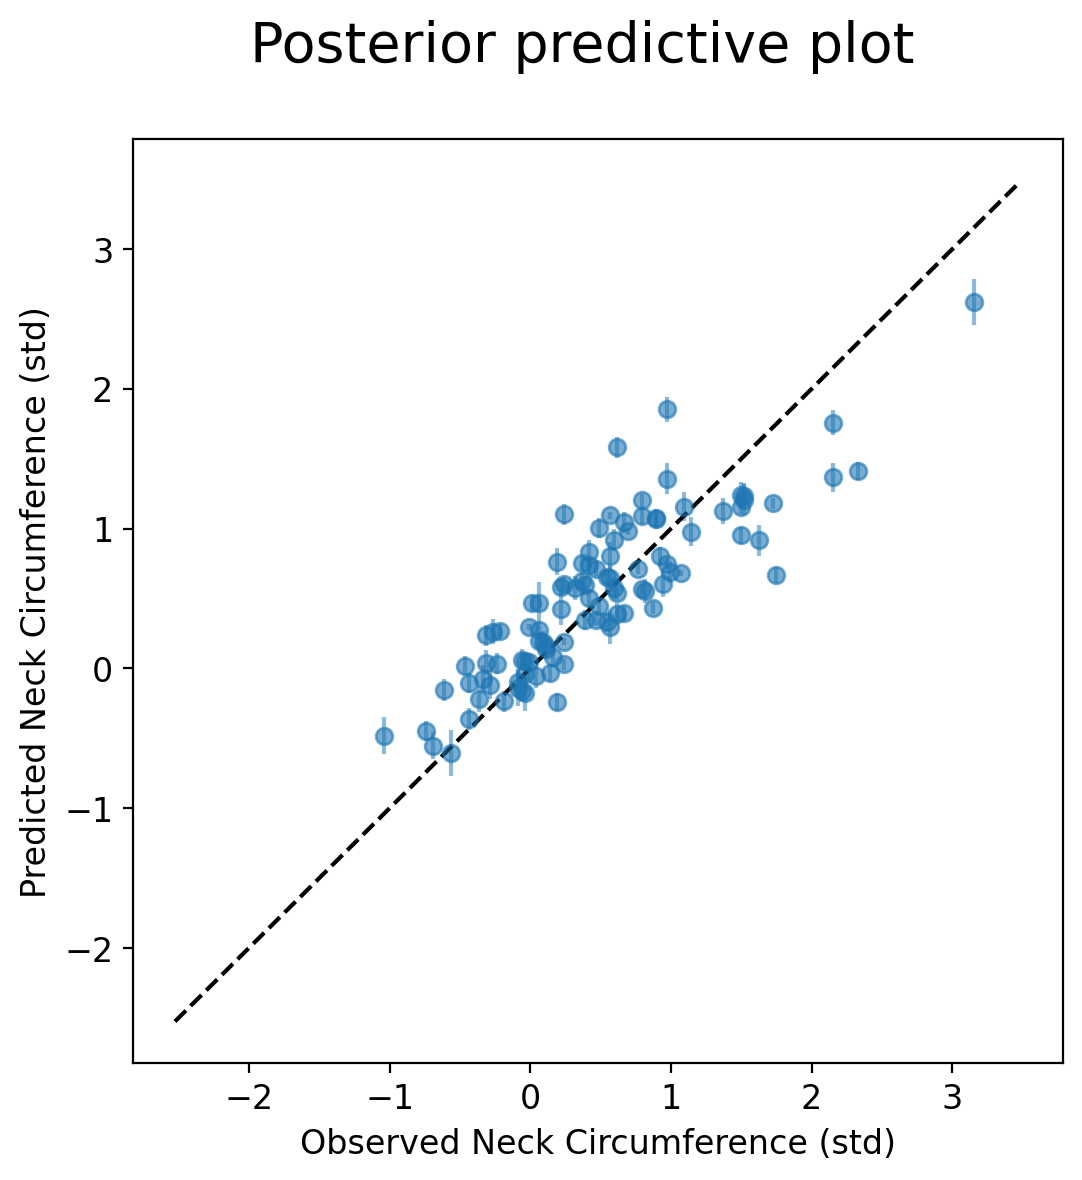

In [45]:
fig, ax = plt.subplots(figsize=(6, 6))
fig.suptitle("Posterior predictive plot", fontsize= 20)
plt.errorbar(
    ansur_circ_std[:100],
    neck_sim_std[:100],
    alpha=0.5,
    yerr=np.abs(np.array(neck_sim) - mu_PI.min(dim="hdi").to_array()).values[:,:100],
    fmt="C0o", 
)
ax.scatter(ansur_circ_std[:100], neck_sim_std[:100], alpha= 0.2)
min_x, max_x = ansur_circ_std.min(), ansur_circ_std.max()
ax.plot([min_x, max_x], [min_x, max_x], "k--")
ax.set_ylabel("Predicted Neck Circumference (std)")
ax.set_xlabel("Observed Neck Circumference (std)");

### Predict a specific individual
> Female of Height 161cm and BMI 24kg / m^2

> Male of Height 175cm and BMI 25kg / m^2

In [46]:
# Distribution for specific values of height and BMI
female_height = 161;female_BMI = 24
male_height = 175;male_BMI = 25
viva50F_F = norm.rvs(loc= (idata_df[("posterior", "alpha[0]", 0)] + idata_df[("posterior", "gamma[0]", 0)] * (female_BMI - bmi_mean) + idata_df[("posterior", "beta[0]", 0)] * (female_height - height_mean)), scale=idata_df[("posterior", "sigma")])
viva50F_M = norm.rvs(loc= (idata_df[("posterior", "alpha[1]", 1)] + idata_df[("posterior", "gamma[1]", 1)] * (female_BMI - bmi_mean) + idata_df[("posterior", "beta[1]", 1)] * (female_height - height_mean)), scale=idata_df[("posterior", "sigma")])
viva50M_F = norm.rvs(loc= (idata_df[("posterior", "alpha[0]", 0)] + idata_df[("posterior", "gamma[0]", 0)] * (male_BMI - bmi_mean) + idata_df[("posterior", "beta[0]", 0)] * (male_height - height_mean)), scale=idata_df[("posterior", "sigma")])
viva50M_M = norm.rvs(loc= (idata_df[("posterior", "alpha[1]", 1)] + idata_df[("posterior", "gamma[1]", 1)] * (male_BMI - bmi_mean) + idata_df[("posterior", "beta[1]", 1)] * (male_height - height_mean)), scale=idata_df[("posterior", "sigma")])

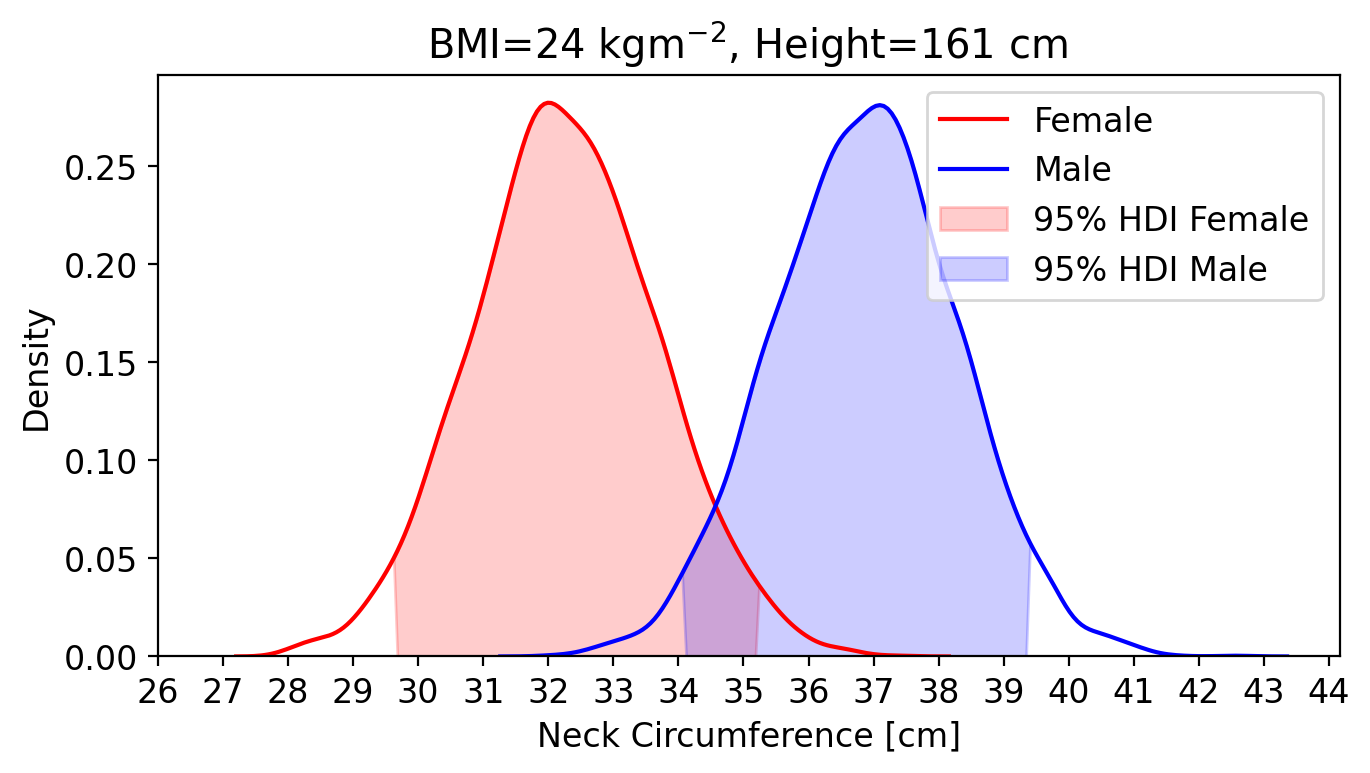

In [47]:
#| label: fig-HBM-prediction
#| fig-cap: "Prediction of Neck Circumference distribution for a specific Height and BMI"
f, ax0 = plt.subplots(1,1,figsize=(7, 4))
ax0.set_title("BMI=24 kgm$^{-2}$, Height=161 cm ")
sns.kdeplot(viva50F_F, color="r", ax=ax0)
sns.kdeplot(viva50F_M, color="b", ax=ax0)
kde_female_x, kde_female_y = ax0.lines[0].get_data()
low_female_int, high_female_int = az.hdi(viva50F_F[~np.isnan(viva50F_F)], hdi_prob=.95)
ax0.fill_between(kde_female_x, kde_female_y, where=(low_female_int< kde_female_x)& ( kde_female_x <high_female_int), color="red", alpha= 0.2, label="95% HDI Female",interpolate=True)
kde_male_x, kde_male_y = ax0.lines[1].get_data()
low_male_int, high_male_int = az.hdi(viva50F_M[~np.isnan(viva50F_M)])
ax0.fill_between(kde_male_x, kde_male_y, where=(low_male_int< kde_male_x)& ( kde_male_x <high_male_int), color="blue", alpha= 0.2, label="95% HDI Male",interpolate=True)
start, end = ax0.get_xlim()
ax0.xaxis.set_ticks(np.arange(np.round(start), end, 1))
ax0.set(xlabel="Neck Circumference [cm]")
ax0.legend(["Female","Male", "95% HDI Female","95% HDI Male"])
f.tight_layout()

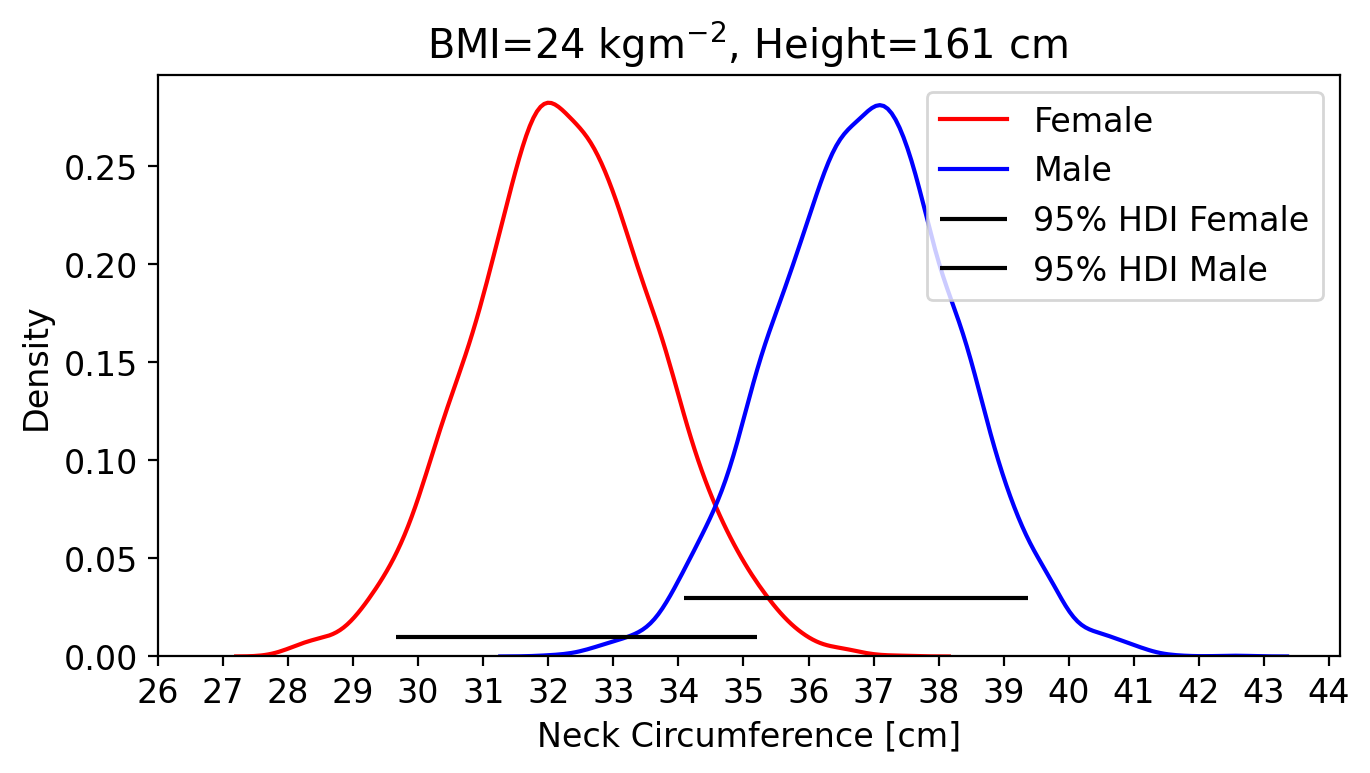

In [48]:
f, ax0 = plt.subplots(1,1,figsize=(7, 4))
ax0.set_title("BMI=24 kgm$^{-2}$, Height=161 cm ")
sns.kdeplot(viva50F_F, color="r", ax=ax0)
sns.kdeplot(viva50F_M, color="b", ax=ax0)
kde_female_x, kde_female_y = ax0.lines[0].get_data()
low_female_int, high_female_int = az.hdi(viva50F_F[~np.isnan(viva50F_F)], hdi_prob=.95)

ax0.hlines(0.01,low_female_int, high_female_int, "black" )
ax0.hlines(0.03,low_male_int, high_male_int, "black" )
# ax0.fill_between(kde_female_x, kde_female_y, where=(low_female_int< kde_female_x)& ( kde_female_x <high_female_int), color="red", alpha= 0.2, label="95% HDI Female",interpolate=True)
kde_male_x, kde_male_y = ax0.lines[1].get_data()
low_male_int, high_male_int = az.hdi(viva50F_M[~np.isnan(viva50F_M)])
# ax0.fill_between(kde_male_x, kde_male_y, where=(low_male_int< kde_male_x)& ( kde_male_x <high_male_int), color="blue", alpha= 0.2, label="95% HDI Male",interpolate=True)
# sns.kdeplot(viva50F_M - viva50F_F, color="black", alpha =0.5,ax=ax0)
start, end = ax0.get_xlim()
ax0.xaxis.set_ticks(np.arange(np.round(start), end, 1))
ax0.set(xlabel="Neck Circumference [cm]")
ax0.legend(["Female","Male", "95% HDI Female","95% HDI Male"])
f.tight_layout()

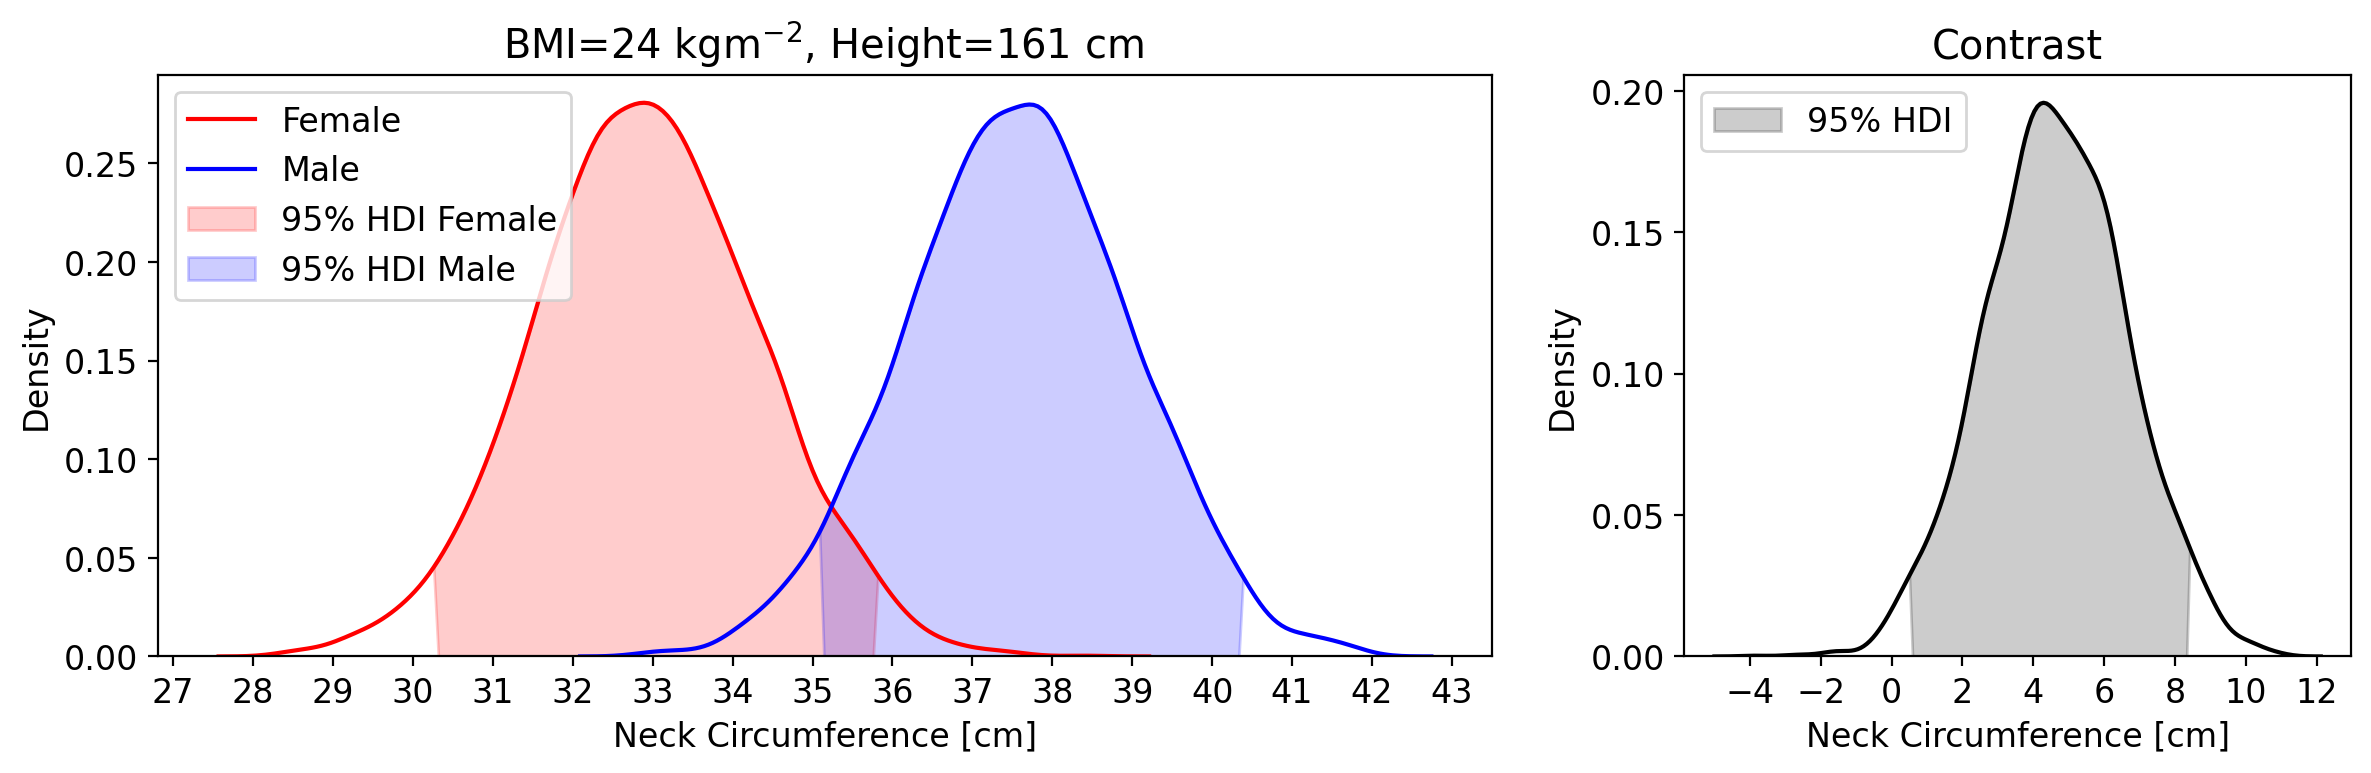

In [58]:
f, (ax0,ax1) = plt.subplots(1,2,figsize=(12, 4),gridspec_kw={'width_ratios': [2, 1]})
ax0.set_title("BMI=24 kgm$^{-2}$, Height=161 cm ")
sns.kdeplot(viva50F_F, color="r", ax=ax0)
sns.kdeplot(viva50F_M, color="b", ax=ax0)
kde_female_x, kde_female_y = ax0.lines[0].get_data()
low_female_int, high_female_int = az.hdi(viva50F_F[~np.isnan(viva50F_F)], hdi_prob=.95)
ax0.fill_between(kde_female_x, kde_female_y, where=(low_female_int< kde_female_x)& ( kde_female_x <high_female_int), color="red", alpha= 0.2, label="95% HDI Female",interpolate=True)
kde_male_x, kde_male_y = ax0.lines[1].get_data()
low_male_int, high_male_int = az.hdi(viva50F_M[~np.isnan(viva50F_M)])
ax0.fill_between(kde_male_x, kde_male_y, where=(low_male_int< kde_male_x)& ( kde_male_x <high_male_int), color="blue", alpha= 0.2, label="95% HDI Male",interpolate=True)
# sns.kdeplot(viva50F_M - viva50F_F, color="black", alpha =0.5,ax=ax0)
start, end = ax0.get_xlim()
ax0.xaxis.set_ticks(np.arange(np.round(start), end, 1))
ax0.set(xlabel="Neck Circumference [cm]")
ax0.legend(["Female","Male", "95% HDI Female","95% HDI Male"])


ax1.set_title("Contrast");ax1.set(xlabel="Neck Circumference [cm]")
sns.kdeplot((viva50F_M -viva50F_F)  , color="black", ax=ax1)
kde_contrast_x, kde_contrast_y = ax1.lines[0].get_data()
low_contrast_int, high_contrast_int = az.hdi((viva50F_M -viva50F_F)[~np.isnan(viva50F_M -viva50F_F)], hdi_prob=.95)
ax1.fill_between(kde_contrast_x, kde_contrast_y, where=(low_contrast_int< kde_contrast_x)& ( kde_contrast_x <high_contrast_int), color="black", alpha= 0.2, label="95% HDI",interpolate=True)
start, end = ax1.get_xlim()
ax1.xaxis.set_ticks(np.arange(np.round(start)+ 2 , end, 2))
ax1.legend()

f.tight_layout()
f.savefig("../images/Neck_circumference.png")

### Comparing Average 50M vs 50F

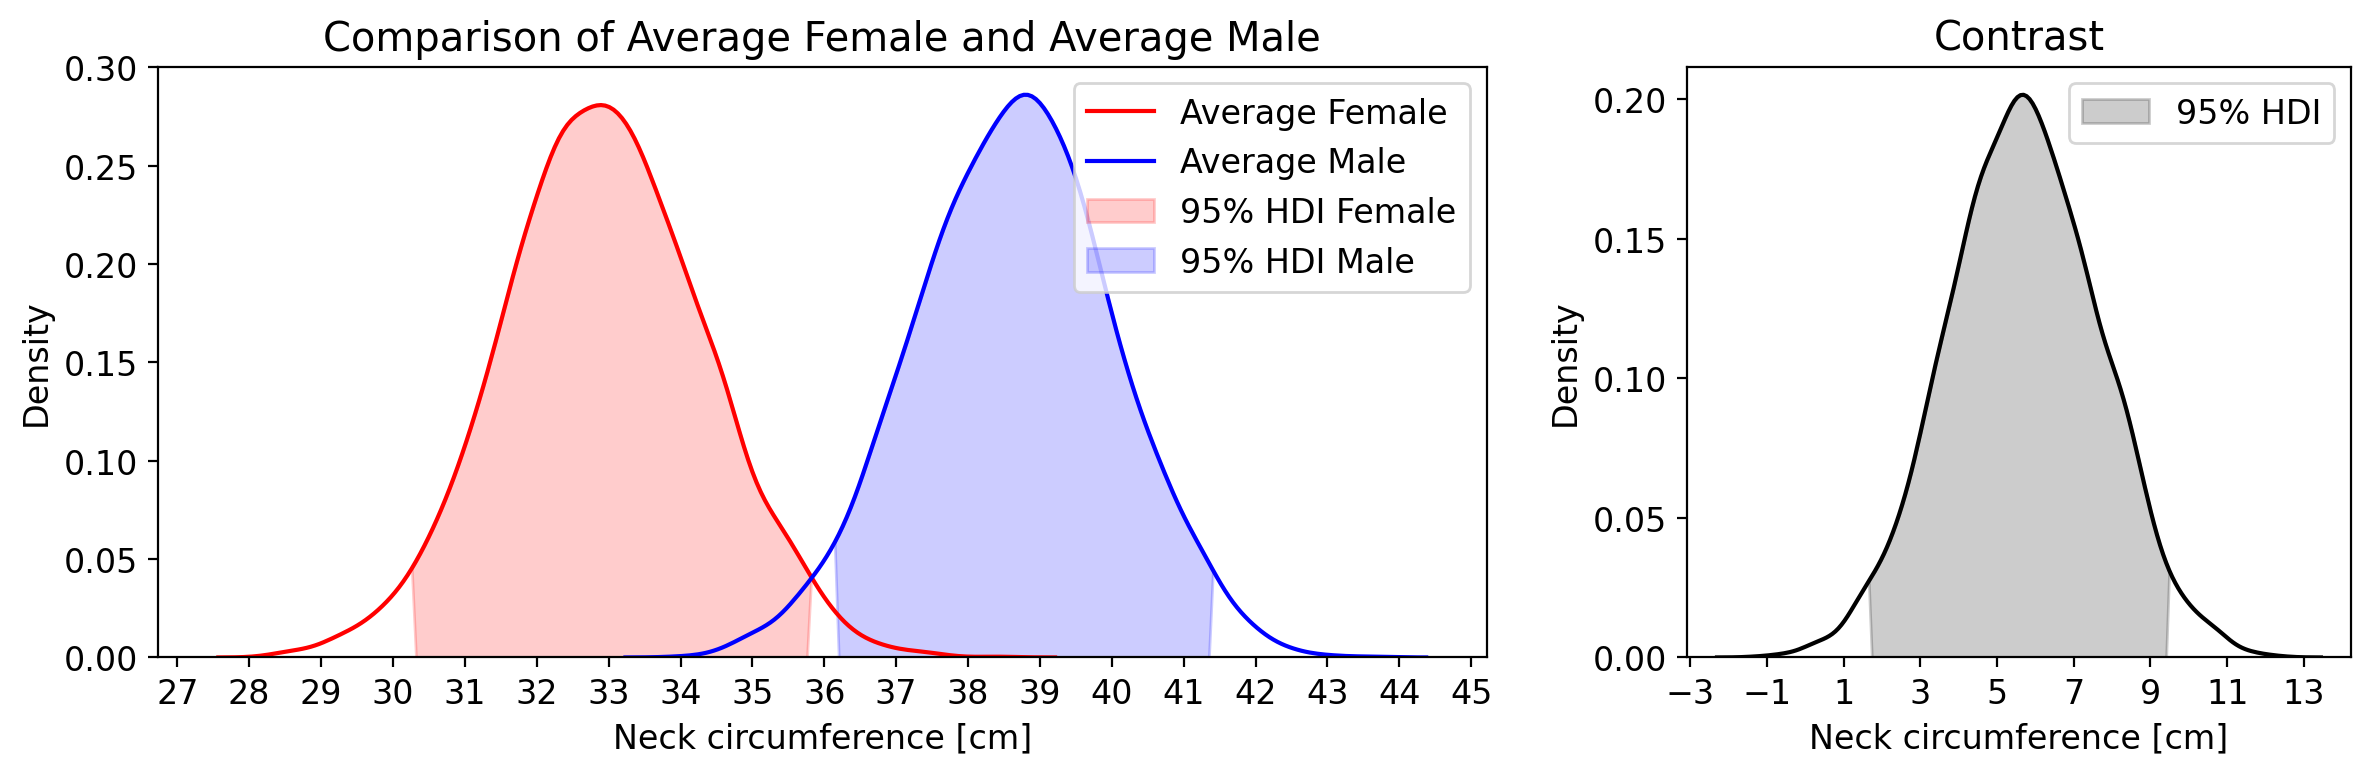

In [57]:
f, (ax0,ax1) = plt.subplots(1,2,figsize=(12, 4),gridspec_kw={'width_ratios': [2, 1]})
ax0.set_title("Comparison of Average Female and Average Male")
sns.kdeplot(viva50F_F, color="red", ax=ax0)
sns.kdeplot(viva50M_M, color="b", ax=ax0)
kde_female_x, kde_female_y = ax0.lines[0].get_data()
low_female_int, high_female_int = az.hdi(viva50F_F[~np.isnan(viva50F_F)], hdi_prob=.95)
ax0.fill_between(kde_female_x, kde_female_y, where=(low_female_int< kde_female_x)& ( kde_female_x <high_female_int), color="r", alpha= 0.2 ,label="95% HDI Female",interpolate=True)
kde_male_x, kde_male_y = ax0.lines[1].get_data()
low_male_int, high_male_int = az.hdi(viva50M_M[~np.isnan(viva50M_M)])
ax0.fill_between(kde_male_x, kde_male_y, where=(low_male_int< kde_male_x)& ( kde_male_x <high_male_int), color="b", alpha= 0.2, label="95% HDI Male",interpolate=True)
# sns.kdeplot(viva50M_M - viva50F_F, color="black", alpha =0.5,ax=ax0)
start, end = ax0.get_xlim()
ax0.xaxis.set_ticks(np.arange(np.round(start), end, 1))
ax0.set(xlabel="Neck circumference [cm]")
ax0.legend(["Average Female","Average Male", "95% HDI Female","95% HDI Male"])


ax1.set_title("Contrast");ax1.set(xlabel="Neck circumference [cm]")
sns.kdeplot((viva50M_M -viva50F_F)  , color="black", ax=ax1)
kde_contrast_x, kde_contrast_y = ax1.lines[0].get_data()
low_contrast_int, high_contrast_int = az.hdi((viva50M_M -viva50F_F)[~np.isnan(viva50M_M -viva50F_F)], hdi_prob=.95)
ax1.fill_between(kde_contrast_x, kde_contrast_y, where=(low_contrast_int< kde_contrast_x)& ( kde_contrast_x <high_contrast_int), color="black", alpha= 0.2, label="95% HDI",interpolate=True)
start, end = ax1.get_xlim()
ax1.xaxis.set_ticks(np.arange(np.round(start), end, 2))
ax1.legend()

f.tight_layout()
f.savefig("../images/Neck_circumference_Average.png")

## Plot DIfferent Percentiles

In [51]:
# Distribution for specific values of height and BMI
# data of percentiles taken from  https://ourworldindata.org/human-height 

height_5th_F = 150.6; BMI_5th_F= 25;
height_5th_M = 163.2;  BMI_5th_M= 25

height_50th_F = 164.7; BMI_50th_F = 25; 
height_50th_M= 178.4; BMI_50th_ = 25

height_95th_F = 178.9 ; BMI_95th_F = 25
height_95th_M = 193.6 ; BMI_95th_M= 25

# viva50F_F = this one has the height and BMI of female 50th and posterior of female (0) - female 100%
# viva50F_M = this one has the height and BMI of female 50th and posterior of males (1) - male with female size
viva50F_F = norm.rvs(loc= (idata_df[("posterior", "alpha[0]", 0)] + idata_df[("posterior", "gamma[0]", 0)] * (BMI_50th_F - bmi_mean) + idata_df[("posterior", "beta[0]", 0)] * (height_50th_F - height_mean)), scale=idata_df[("posterior", "sigma")])
viva50F_M = norm.rvs(loc= (idata_df[("posterior", "alpha[1]", 1)] + idata_df[("posterior", "gamma[1]", 1)] * (BMI_50th_F - bmi_mean) + idata_df[("posterior", "beta[1]", 1)] * (height_50th_F - height_mean)), scale=idata_df[("posterior", "sigma")])
viva50M_F = norm.rvs(loc= (idata_df[("posterior", "alpha[0]", 0)] + idata_df[("posterior", "gamma[0]", 0)] * (BMI_50th_ - bmi_mean) + idata_df[("posterior", "beta[0]", 0)] * (height_50th_M- height_mean)), scale=idata_df[("posterior", "sigma")])
viva50M_M = norm.rvs(loc= (idata_df[("posterior", "alpha[1]", 1)] + idata_df[("posterior", "gamma[1]", 1)] * (BMI_50th_ - bmi_mean) + idata_df[("posterior", "beta[1]", 1)] * (height_50th_M- height_mean)), scale=idata_df[("posterior", "sigma")])

dummy5th_F = norm.rvs(loc= (idata_df[("posterior", "alpha[0]", 0)] + idata_df[("posterior", "gamma[0]", 0)] * (BMI_5th_F - bmi_mean) + idata_df[("posterior", "beta[0]", 0)] * (height_5th_F - height_mean)), scale=idata_df[("posterior", "sigma")])
dummy5th_M = norm.rvs(loc= (idata_df[("posterior", "alpha[1]", 1)] + idata_df[("posterior", "gamma[1]", 1)] * (BMI_5th_M  - bmi_mean) + idata_df[("posterior", "beta[1]", 1)] * (height_5th_M - height_mean)), scale=idata_df[("posterior", "sigma")])

dummy95th_F = norm.rvs(loc= (idata_df[("posterior", "alpha[0]", 0)] + idata_df[("posterior", "gamma[0]", 0)] * (BMI_95th_F - bmi_mean) + idata_df[("posterior", "beta[0]", 0)] * (height_95th_F - height_mean)), scale=idata_df[("posterior", "sigma")])
dummy95th_M = norm.rvs(loc= (idata_df[("posterior", "alpha[1]", 1)] + idata_df[("posterior", "gamma[1]", 1)] * (BMI_95th_M - bmi_mean) + idata_df[("posterior", "beta[1]", 1)] * (height_95th_M - height_mean)), scale=idata_df[("posterior", "sigma")])



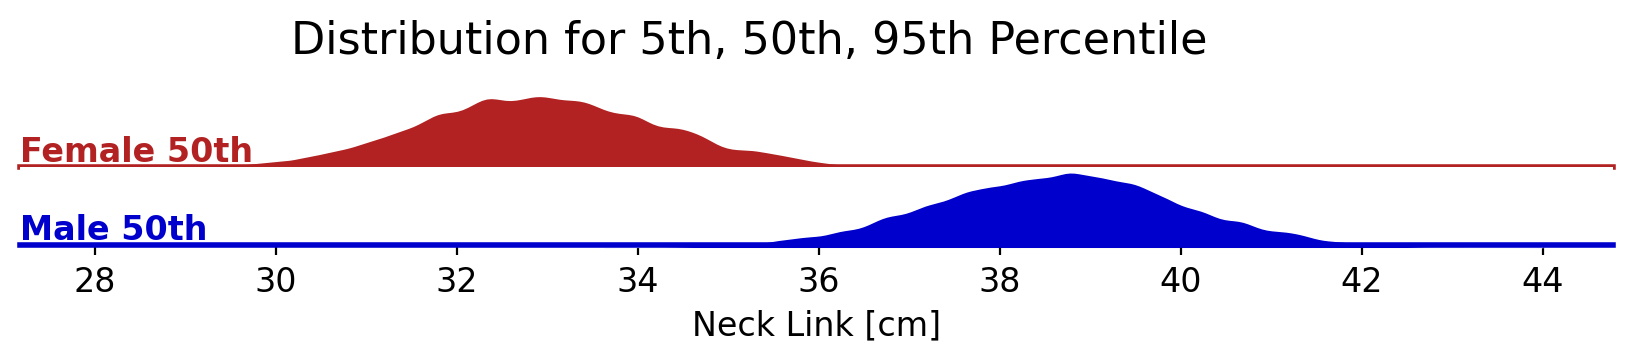

In [59]:
# Combine the data into a DataFrame
groups =['Female 50th'] * 4000 + ['Male 50th'] * 4000 
x = np.concatenate([viva50F_F, viva50M_M ])

df = pd.DataFrame(dict(x=x, g=groups))

# Initialize the FacetGrid object

g = sns.FacetGrid(df, row="g", hue="g", aspect=10, height=.9, palette=[  "firebrick", "mediumblue"])
# Draw the densities in a few steps
g.map(sns.kdeplot, "x",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "x")

# # Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.001)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
g.fig.suptitle("Distribution for 5th, 50th, 95th Percentile", fontsize=16)
# Set the x-axis label for the last subplot
g.set_axis_labels("Neck Link [cm]", "")
plt.show()

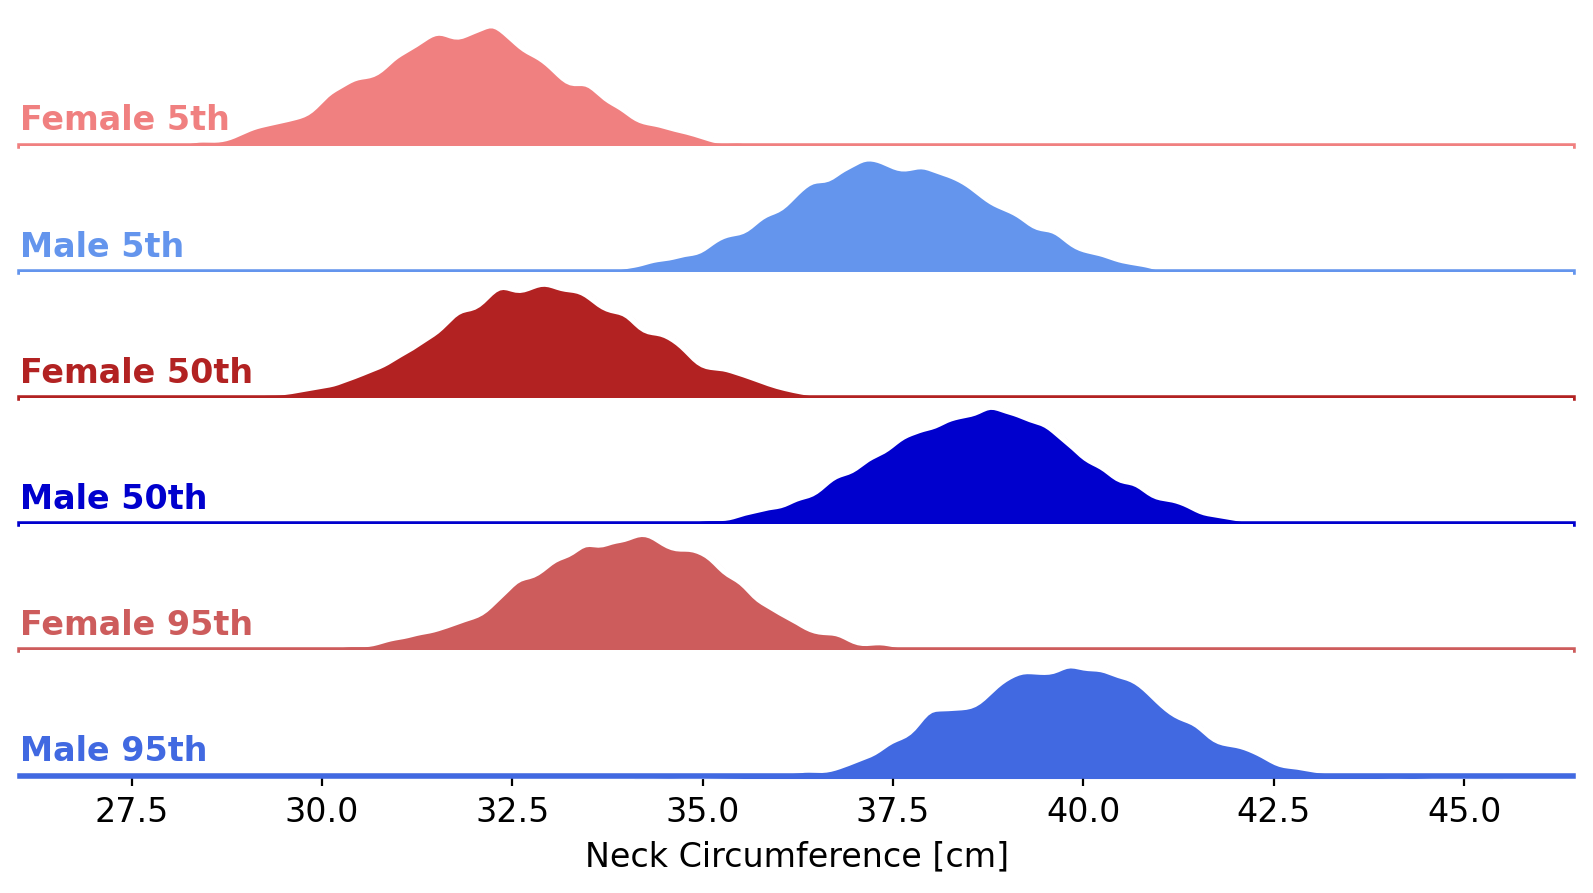

In [60]:
# Combine the data into a DataFrame
groups = ['Female 5th'] * 4000 + ['Male 5th'] * 4000 + ['Female 50th'] * 4000 + ['Male 50th'] * 4000 + ['Female 95th'] * 4000 + ['Male 95th'] * 4000 
x = np.concatenate([dummy5th_F, dummy5th_M, viva50F_F, viva50M_M ,dummy95th_F, dummy95th_M])

df = pd.DataFrame(dict(x=x, g=groups))

# Initialize the FacetGrid object

g = sns.FacetGrid(df, row="g", hue="g", aspect=11, height=.8, palette=["lightcoral", "cornflowerblue",  "firebrick", "mediumblue", "indianred" ,"royalblue"])
# Draw the densities in a few steps
g.map(sns.kdeplot, "x",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "x")

# # Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.001)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
# g.fig.suptitle("Distribution for 5th, 50th, 95th Percentile", fontsize=16)
# Set the x-axis label for the last subplot
g.set_axis_labels("Neck Circumference [cm]", "")
plt.show()

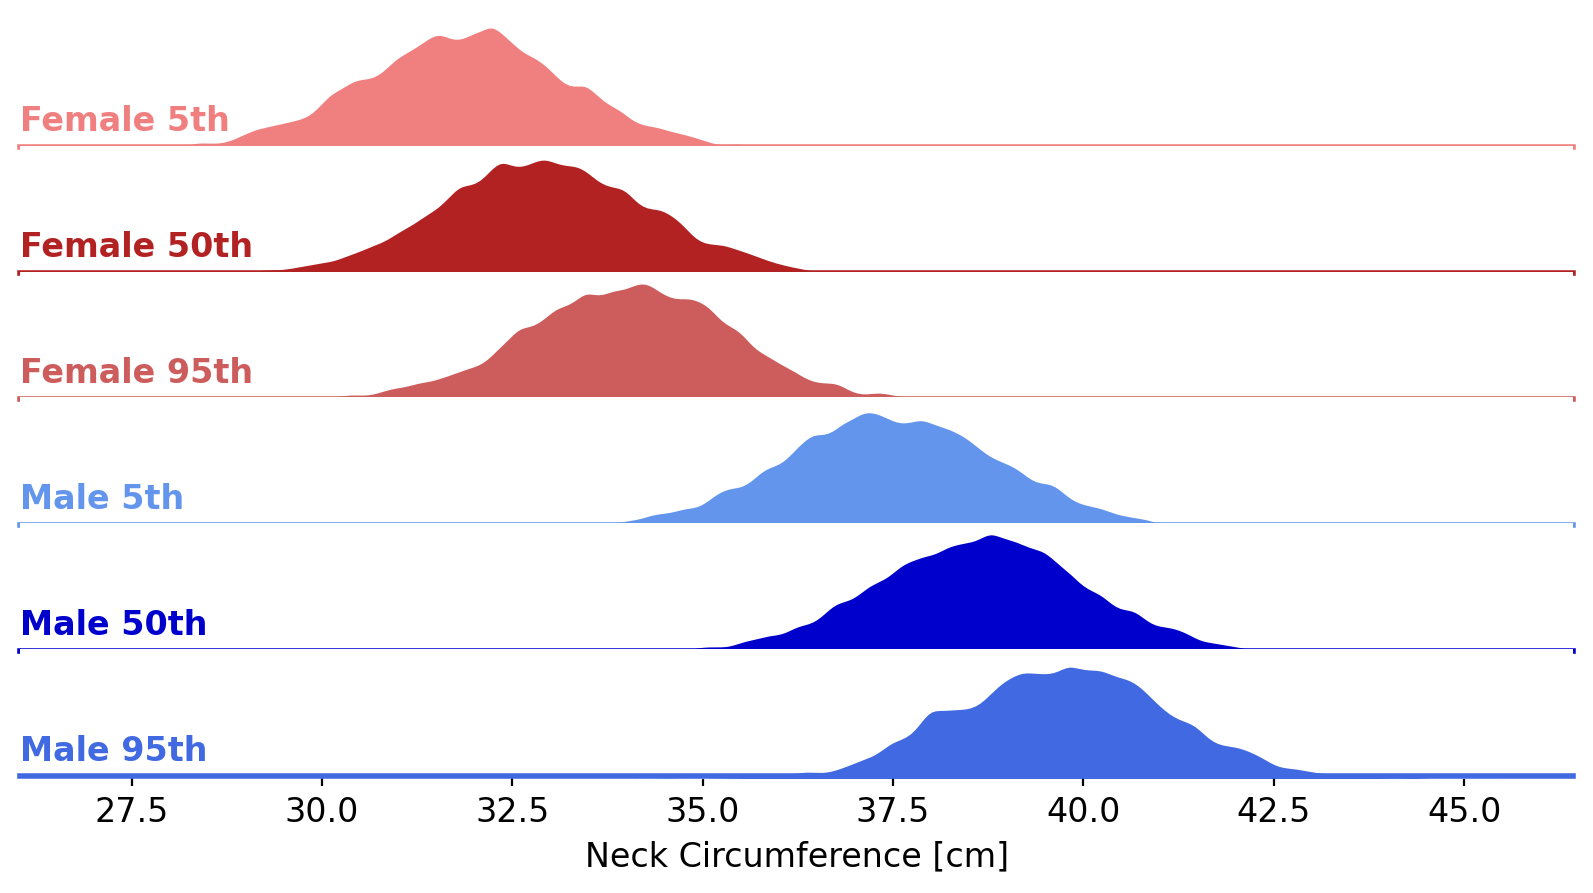

In [54]:
# Combine the data into a DataFrame
groups = ['Female 5th'] * 4000 + ['Female 50th'] * 4000  + ['Female 95th'] * 4000 + ['Male 5th'] * 4000 +  ['Male 50th'] * 4000 +  ['Male 95th'] * 4000 
x = np.concatenate([dummy5th_F, viva50F_F ,dummy95th_F,  dummy5th_M, viva50M_M , dummy95th_M])

df = pd.DataFrame(dict(x=x, g=groups))

# Initialize the FacetGrid object

g = sns.FacetGrid(df, row="g", hue="g", aspect=11, height=.8, palette=["lightcoral", "firebrick", "indianred", "cornflowerblue", "mediumblue","royalblue",])
# Draw the densities in a few steps
g.map(sns.kdeplot, "x",
      bw_adjust=0.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw_adjust=0.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "x")

# text=[ "150.6 $\\mathrm{cm}$ - 25 $\\mathrm{kg/m^2}$",
#       "163.2 $\\mathrm{cm}$ - 25 $\\mathrm{kg/m^2}$",
#       "164.7 $\\mathrm{cm}$ - 25 $\\mathrm{kg/m^2}$",
#       "178.4 $\\mathrm{cm}$ - 25 $\\mathrm{kg/m^2}$",
#       "178.9 $\\mathrm{cm}$ - 25 $\\mathrm{kg/m^2}$",
#       "193.4 $\\mathrm{cm}$ - 25 $\\mathrm{kg/m^2}$"]
# for i, ax in enumerate(g.axes.flat):
#     ax.text(42.9, 0.02, text[i], fontweight="bold", 
#             fontsize=10,
#             color=ax.lines[-1].get_color())

# # Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.01)


# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
# g.fig.suptitle("5th, 50th, 95th Percentiles", fontsize=16,color = "slategrey", fontweight= 'bold')
# Set the x-axis label for the last subplot
g.set_axis_labels("Neck Circumference [cm]", "")
plt.show()

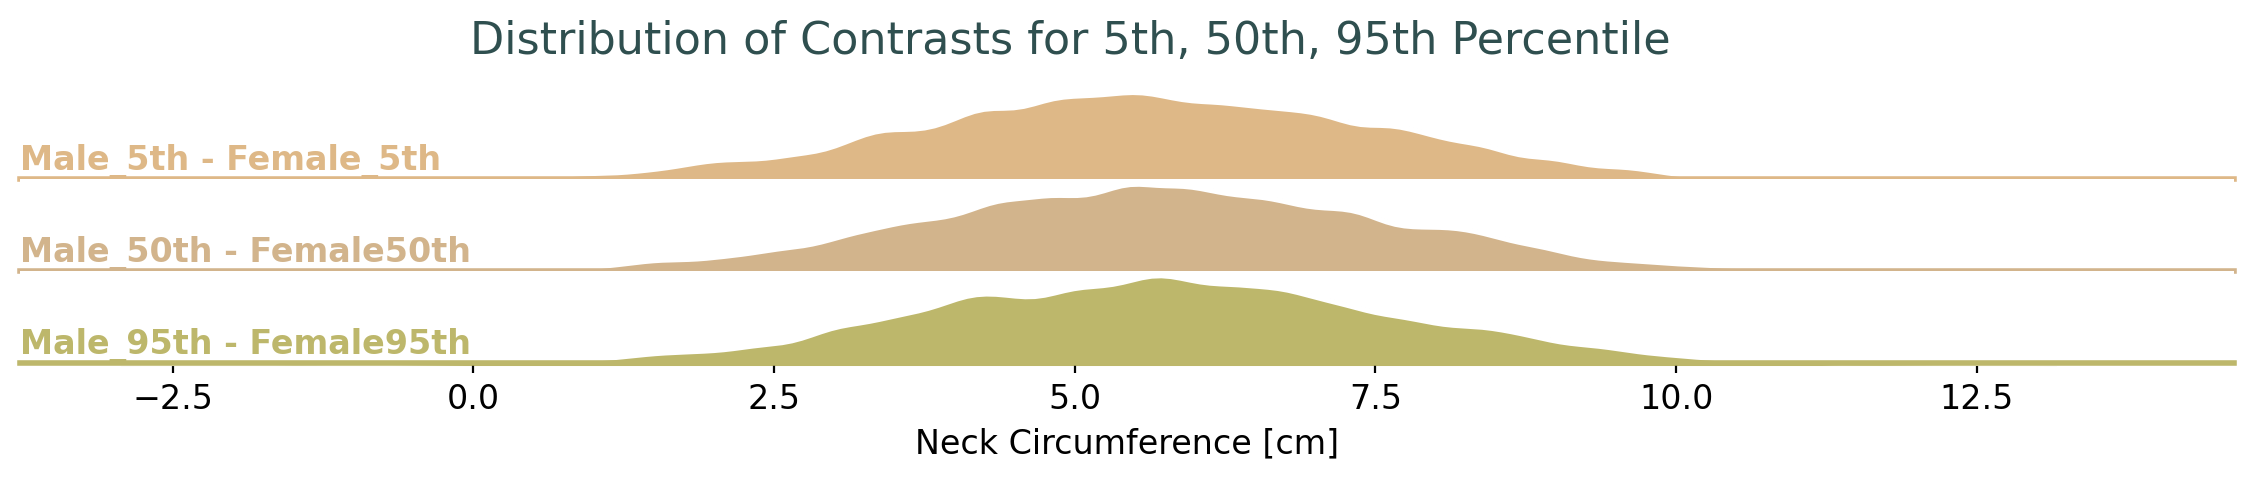

In [55]:
# Combine the data into a DataFrame
groups = ['Male_5th - Female_5th'] * 4000 + ['Male_50th - Female50th'] * 4000  + ['Male_95th - Female95th'] * 4000  
x = np.concatenate([(dummy5th_M - dummy5th_F)  , ( viva50M_M - viva50F_F ) ,( dummy95th_M - dummy95th_F)])

df = pd.DataFrame(dict(x=x, g=groups))

# Initialize the FacetGrid object

g = sns.FacetGrid(df, row="g", hue="g", aspect=15, height=.8, palette=["burlywood",  "tan", "darkkhaki"])
# Draw the densities in a few steps
g.map(sns.kdeplot, "x",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "x")

# # Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.001)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
g.fig.suptitle("Distribution of Contrasts for 5th, 50th, 95th Percentile", fontsize=16, color="darkslategray")
# Set the x-axis label for the last subplot
g.set_axis_labels("Neck Circumference [cm]", "")
plt.show()

In [56]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.stats import gaussian_kde


# Combine the data into a DataFrame
groups = ['Female_5th'] * 4000 + ['Male_5th'] * 4000 + ['Female_50th'] * 4000 + ['Male_50th'] * 4000 + ['Female_95th'] * 4000 + ['Male_95th'] * 4000
x = np.concatenate([dummy5th_F, dummy5th_M, viva50F_F, viva50M_M, dummy95th_F, dummy95th_M])

df = pd.DataFrame(dict(x=x, g=groups))

# Define the custom color palette
colors = ["lightcoral", "cornflowerblue", "indianred", "royalblue", "firebrick", "mediumblue"]

# Create subplots
fig = make_subplots(rows=len(df['g'].unique()), cols=1, shared_xaxes=True, vertical_spacing=0.02)

# Add density traces for each group
for i, group in enumerate(df['g'].unique()):
    group_data = df[df['g'] == group]['x']
    kde = gaussian_kde(group_data)
    kde_x = np.linspace(min(group_data), max(group_data), 1000)
    kde_y = kde(kde_x)
    
    fig.add_trace(go.Scatter(
        x=kde_x,
        y=kde_y,
        mode='lines',
        fill='tozeroy',
        line=dict(color=colors[i]),
        name=group
    ), row=i+1, col=1)

    # Add group label to the y-axis
    fig.update_yaxes(showticklabels= False , showgrid=False, row=i+1, col=1)
    
    # Add annotation for the group label on the x-axis
    fig.add_annotation(
        xref='x',
        yref='y',
        x=kde_x[0],  # Place the annotation at the start of the x-axis
        y=0,  # Place the annotation at the bottom of the subplot
        text=group,
        showarrow=False,
        font=dict(size=16, color=colors[i], family="Arial Black"),
        xanchor='left',  # Align the text to the left
        yanchor='bottom',  # Align the text to the bottom
        row=i+1,
        col=1
    )

#fig.update_xaxes(title_text="Neck Circumference [cm]")
# Update layout for the plot
fig.update_layout(
   title={
        'text': "Neck Circumference Distribution for 5th, 50th, 95th Percentile",
        'y': 0.95,  # Adjust the vertical position of the title
        'x': 0.5,   # Center the title horizontally
        'xanchor': 'center',
        'yanchor': 'top',
        'font': {
            'size': 20  # Change the font size of the title
        }},
    showlegend=False,
    height=600,  # Adjust height as needed
)

# Show the plot
fig.show()

